# Widzenie komputerowe - Laboratoria nr 13

## Opis laboratoriów

- reimplementacja architektury neuronowej,
- przeprowadzenie eksperymentów z architekturami neuronowymi,
- prezentacja wyników działania sieci neuronowej

## Funkcje pomocnicze

### Niezbędne biblioteki


In [1]:
!nvidia-smi

Mon Jun  9 09:45:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q tfds-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 44.5 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import cv2
import PIL
import imageio
from IPython.display import Image

from pprint import pprint

### Wizualizacja



Skrypt do wyżwietlania obrazów BGR oraz Grayscale.

In [4]:
def show_images(images):
  num_images = images.shape[0]
  num_rows = (num_images - 1 // 10)
  num_cols = 10
  fig = plt.figure(figsize=(num_rows * 10, num_cols * 10))

  for i in range(images.shape[0]):
      plt.subplot(num_rows, num_cols, i+1)
      plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()


def show_gif(images):
  filename = 'tmp.gif'

  _steps_outputs = tf.image.resize(steps_outputs, (256, 256))
  _steps_outputs = tf.cast(_steps_outputs * 127.5 + 127.5, tf.uint8).numpy()

  with imageio.get_writer(filename, mode='I') as writer:
    for image in _steps_outputs:
      writer.append_data(image)

  with open(filename, 'rb') as file:
      display(Image(file.read()))

# Reimplementacja architektury neuronowej

Reimplementacja architektury neuronowej ma na celu odtworzenie i weryfikację rezultatów zaprezentowanych w oryginalnej pracy przedstawiającej daną architekturę. W skład reimplementacji można zaliczyć następujące kroki:
- dobór oraz przygotowanie zbioru danych,
- zapoznanie się z architekturą neuronową,
- prototypowanie i testowa inferencja modelu,
- przeprowadzenie analogicznych wyników biorąc pod uwagę hiperparametry uczenia



## Zbiór danych

Dobrym początkiem pracy z reimplementacją architektury neuronowej jest odpowiedni dobór oraz przygotowanie zbioru danych.

Omawianą architekturą jest [Generative Adversarial Network](https://arxiv.org/abs/1406.2661) dla obrazów, a więc przetwarzanymi danymi powinny być dane wizyjne. Celem reimplementacji jest potwierdzenie możliwości generacyjnych modelu, co nie jest bezpośrednio związane z charakterystyką danych wejściowych. Stąd, dobrym wyborem danych wejściowych wydaje się być zbiór MNIST, który jest wystarczająco zróżnicowany oraz mały, przez co potencjalne uczenie modelu na zbiorze może być efektywnie wykonane.

In [5]:
train_ds, info = tfds.load('mnist', split='train', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.EIID6H_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.EIID6H_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


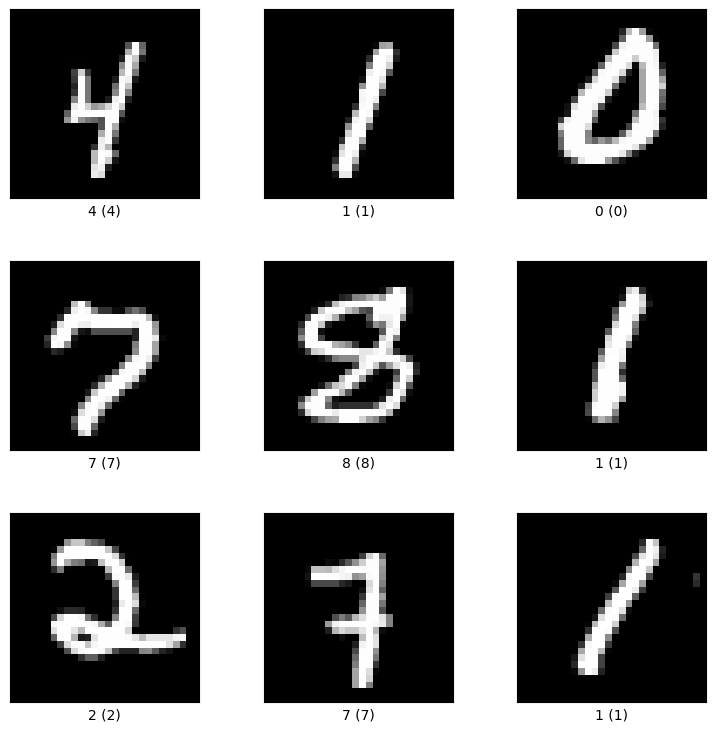

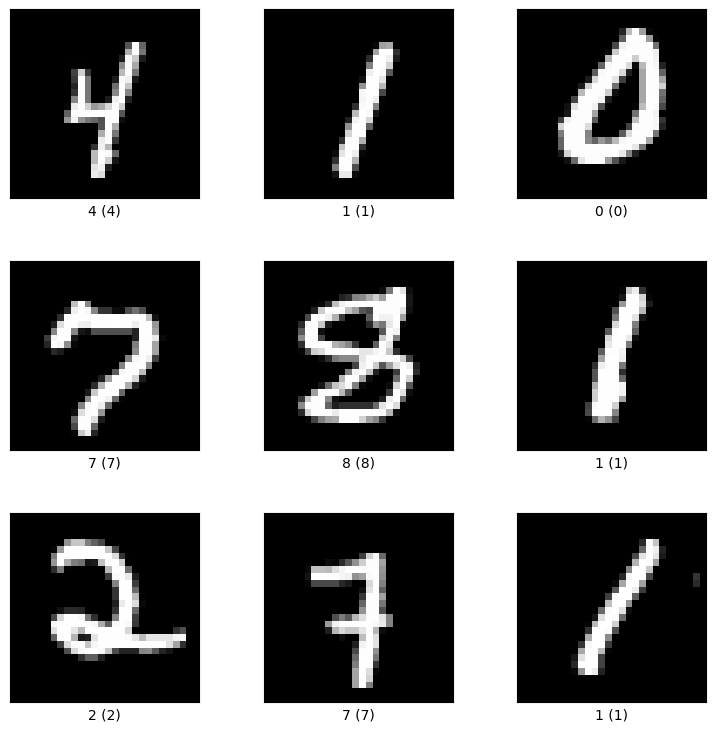

In [6]:
tfds.show_examples(train_ds, info)

## Architektura neuronowa

**Generative Adversarial Network** (GAN) jest to ogólna architektura sieci neuronowej zaprezentowana pierwotnie przez Ian J. Goodfellow w swojej rozprawie doktorskiej, a następnie zaprezentowana w formie artykułu naukowego pod tym tytułem ''Generative Adversarial Network''.

Sieci GAN wykorzystywane są w głównej mierze do odkrywania dystrybucji danych wejściowych oraz generowania nowych danych z poznanej wcześniej dystrybucji. Ogólny zarys architektury przedstawiony został poniżej.

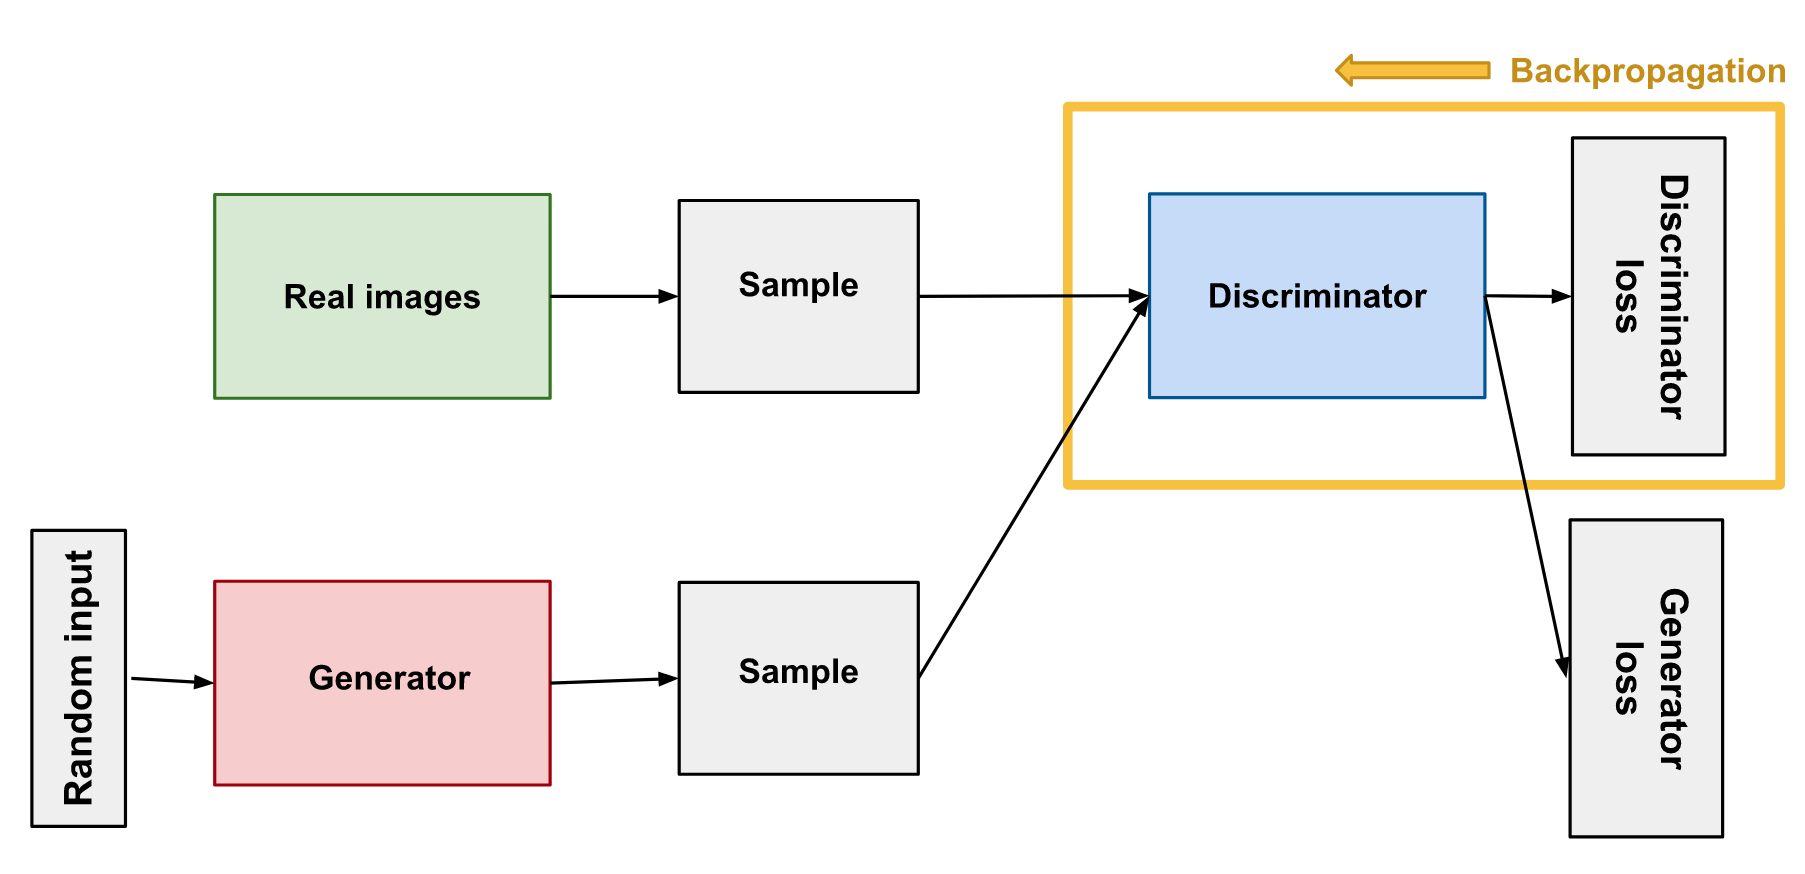

GAN składa się (wg. oryginalnej architektury) z dwóch głównych komponentów: **generatora** oraz **dyskryminatora**. Zadaniem generatora jest generowanie danych, które będą przypominały dane rzeczywiste, natomiast dyskryminator odpowiada za wydanie decyzji czy dane wejściowe pochodzą z prawdziwego rozkładu danych, czy z generatora.

Inspiracją do stworzenia architektury GAN jest problem szukania strategii optymalnej, znanej z **teorii gier**. Problem ten dotyczy gry losowej dla dwóch graczy, w której poszukiwana jest równowaga Nasha (t.j. taka strategia obu graczy, że żadnemu z nich nie opłaca się zmienić swojej strategii względem ustalonej strategii drugiego gracza).

Przekształcając problem poszukiwania równowagi Nasha na architekturę GAN, Goodfellow przedstawił sytuację jako grę pomiędzy generatorem a dyskryminatorem. Gracz generatora stara się oszukać dyskryminator generując takie dane, które będą nierozróżnialne z rzeczywistymi danymi, natomiast gracz dyskryminatora stara się jak najlepiej klasyfikować dane wejściowe.

Przy powyższej definicji problemu możemy zaproponować formalizację celu architektury jako:

$$
min_G max_D V(G,D) = E_x[log(D(x))] + E_z[log(1 - D(G(z)))]
$$

Gdzie G to model generatora, D - dyskryminatora. Powyższy wzór możemy rozważać osobno dla generatora i dyskryminatora. Względem generatora powyższy wzór możemy opisać jako: **generuj obrazy które maksymalizują wyjście dyskryminatora**, natomiast dla dyskryminatora: **maksymalizuj wyjście dla obrazów rzeczywistych i minimalizuj dla obrazów wygenerowanych**.

Przekształcając powyższe wzory na kod programistyczny, otrzymujemy:

In [7]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def min_max_discriminator_loss(real_out, gen_out):
    real_loss = bce(tf.ones_like(real_out), real_out)
    gen_loss = bce(tf.zeros_like(gen_out), gen_out)
    return real_loss + gen_loss


def min_max_generator_loss(gen_out):
    return bce(tf.ones_like(gen_out), gen_out)

Funkcja straty zdefiniowana dla dyskryminatora wykonuje binarną klasyfikację dla obrazów, gdzie klasą dla obrazów rzeczywistych jest 1, dla wygenerowanych 0.

Analogicznie możemy zdefiniować funkcję straty dla generatora.

Inną implementacją zgodną z wcześniej przytoczonym opisem maksymalizacji i minimalizacji wyjścia dyskryminatora jest tzw. **Wasserstein loss**. Zgodnie z nią funkcję straty można rozbić bezpośrednio na dwa komponenty:

- funkcja straty dla dyskryminatora:</br>
$$max D(x) - D(G(z))$$
- funkcja straty dla generatora:</br>
$$max D(G(z))$$


## Prototypowanie

### Generator

W ogólności model generatora można matematycznie przedstawić jako funkcję:

$$G: \mathbb{R}^N \rightarrow \mathbb{R}^{H \times W}$$

Gdzie N to rozmiar danych wejściowycj (np. rozmiar szumu, z którego generujemy dane), a ${H \times W}$ to wysokość i szerokość generowanego obrazu.

A więc, model generatora na wejściu otrzymywać będzie pewien losowy wektor i przekształcać go będzie w dane o rozmiarze zgodnym z obrazami (w tym przypadku dla MNIST: 28 x 28 x 1).

In [8]:
class Generator(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.model = tf.keras.Sequential([
        # flat
        tf.keras.layers.Dense(7*7*256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape([7, 7, 256]),
        # conv without stride (7x7)
        tf.keras.layers.Conv2D(128, 5, 1, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # t_conv with stride (14x14)
        tf.keras.layers.Conv2DTranspose(128, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # conv without stride (14x14)
        tf.keras.layers.Conv2D(64, 5, 1, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # t_conv with stride (28x28)
        tf.keras.layers.Conv2DTranspose(32, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        # conv without stride
        tf.keras.layers.Conv2D(1, 5, 1, 'same', activation='tanh')
    ])

  def call(self, noise, training):
    return self.model(noise, training=training)

In [9]:
generator = Generator()

dummy_input = tf.random.uniform([10, 32], -1, 1)
dummy_output = generator(dummy_input, False)

show_images(tf.clip_by_value(dummy_output, -1, 1))

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: False (of type <class 'bool'>)

### Dyskryminator

Analogicznie możemy zdefiniować dyskryminator jako:

$$D: \mathbb{R}^{H \times W} \rightarrow \mathbb{R}$$

Dyskryminator jako wejście pobiera obrazy i przekształca je do jednej wartości, która w zależności od tego jaką funkcję straty wykorzystamy może oznaczać albo prawdopodobieństwo tego, czy obraz wejściowy jest prawdziwy czy fałszywy, albo wynik, który im większy tym bardziej oznacza, że dane wejściowe są prawdziwe i analogicznie im mniejszy tym bardziej oznacza to, że dane wejściowe są wygenerowane.


In [10]:
class Discriminator(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.image_encoder = tf.keras.Sequential([
        # conv with stride (out = 14x14)
        tf.keras.layers.Conv2D(64, 5, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        # conv with steide (out = 7x7)
        tf.keras.layers.Conv2D(128, 3, 2, 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        # flatten + hidden layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        # prediction (LOGITS!)
        tf.keras.layers.Dense(1)
    ])

  def call(self, images, training=False):
    return self.image_encoder(images, training=training)

In [11]:
discriminator = Discriminator()

dummy_input = tf.random.uniform([10, 28, 28, 1], -1, 1)
dummy_output = discriminator(dummy_input, False)

show_images(dummy_input)
print(dummy_output.numpy())

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: False (of type <class 'bool'>)

### Szum wejściowy

Ostatnim elementem implementacji modelu jest generowanie danych wejściowych. Podstawowym sposobem dostarczania szumu może być próbkowanie pewnego rozkładu danych np. rozkładu normalnego lub nawet jednostajnego.

**Uwaga: generowanie danych wejściowych może być zaimplementowane jako bardziej pomysłowe i może stanowić nawet główny punkt implementacji/usprawnienia modelu GAN.**

In [12]:
class NoiseGenerator(tf.keras.layers.Layer):

  def __init__(self, distribution_size):
    super().__init__()
    self.distribution_size = distribution_size

  def call(self, size):
    return tf.random.uniform([size, self.distribution_size], -1, 1)

# Eksperyment

W ramach eksperymentu wykonane zostanie uczenie powyżej zdefiniowanych komponentów architektury GAN przez ustaloną liczbę epok. W tym celu zdefiniowane zostaną funkcje pomocnicze, zoptymalizowane pod przetwarzanie na jednostkach obliczeniowych GPU.

Funkcja pojedynczej iteracji uczenia modelu polega na:
- odpytaniu dyskryminatora na danych rzeczywistych,
- odpytaniu dyskryminatora na danych wygenerowanych.

Natomiast samo odpytanie testowe modelu polega na jedynie wygenerowaniu danych (bez odpytania dyskryminatora).

In [13]:
def train_step_template(generator, discriminator, noise, d_optim, g_optim, d_loss_f, g_loss_f):

  @tf.function
  def _train_step_template(images, labels):
    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:

      real_out = discriminator(images, training=True)
      gen_out = discriminator(generator(noise(tf.shape(labels)[0]), training=True), training=True)

      d_loss = d_loss_f(real_out, gen_out)
      g_loss = g_loss_f(gen_out)

    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)

    d_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    g_optim.apply_gradients(zip(g_grads, generator.trainable_variables))

  return _train_step_template

In [15]:
def gen_step_template(generator, noise):

  @tf.function
  def _gen_step_template(num_images):
    noise_input = noise(size=num_images)
    generated_images = generator(noise_input, training=False)
    return generated_images

  return _gen_step_template

Ostatnim etapem jest przygotowanie pętli uczenia, która zawiera również przygotowanie danych wejściowych do przetwarzania grupowego.

Najpierw zbiór traningowy (*warto zauważyć, że nie korzystamy ze zbioru testowego!*) jest przetworzony do formatu oczekiwanego przez dyskryminator (t.j. obrazy grayscale o danych zmiennoprzecinkowych z zakresu \[0, 1\]).

Następnie zbiór danych jest przetworzony wiele razy (sterowane parametrem *epochs*), przy czym po każdej epoce wyświetlonych jest 10 losowo wygenerowanych danych.

In [16]:
def preprocess(batch):
  batch['image'] = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch['image'] = batch['image'] * 2 - 1
  return batch

def train(train_step, gen_step, epochs, batch_size):
  _train_ds = train_ds \
    .shuffle(5000) \
    .map(preprocess, num_parallel_calls=8) \
    .batch(batch_size) \
    .prefetch(4)

  for epoch in range(epochs):

    for batch in _train_ds:
      train_step(batch['image'], batch['label'])

    print('Epoch {0}/{1}'.format(epoch, epochs))

    images = gen_step(10)
    show_images(images)

Epoch 0/50


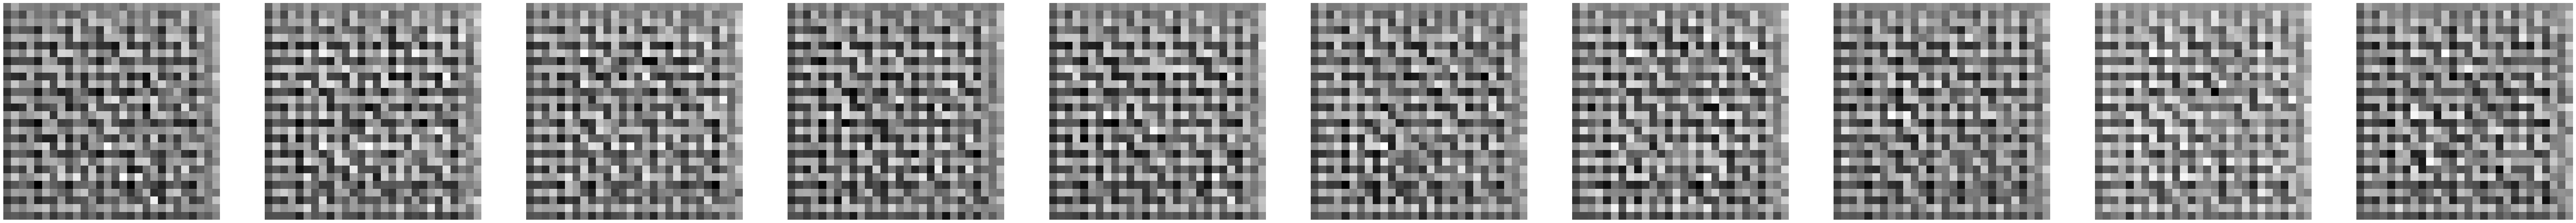

Epoch 1/50


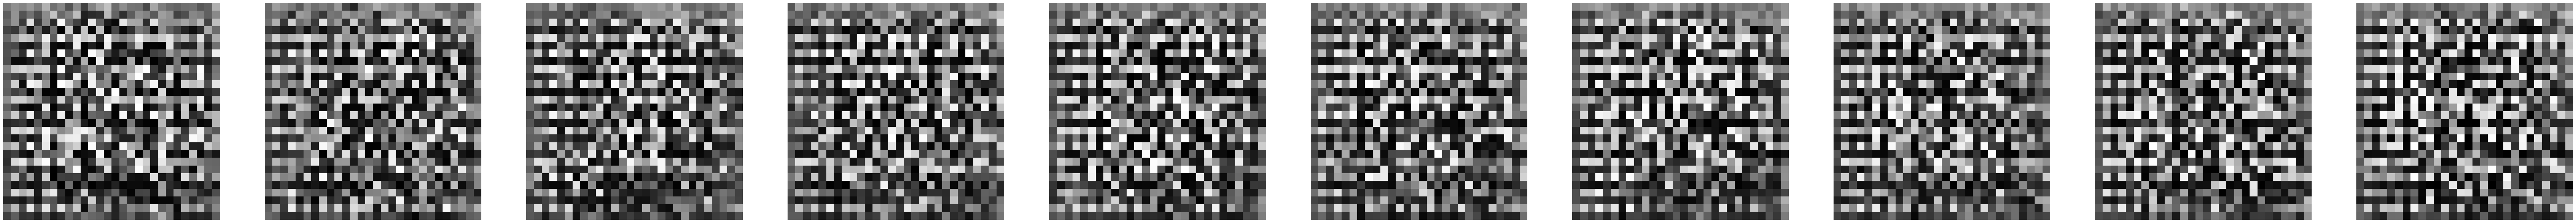

Epoch 2/50


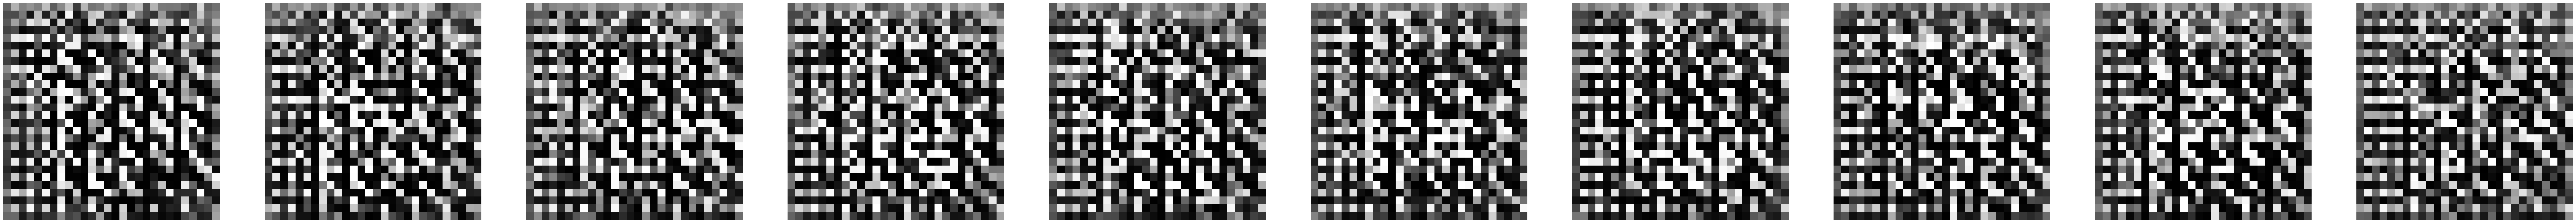

Epoch 3/50


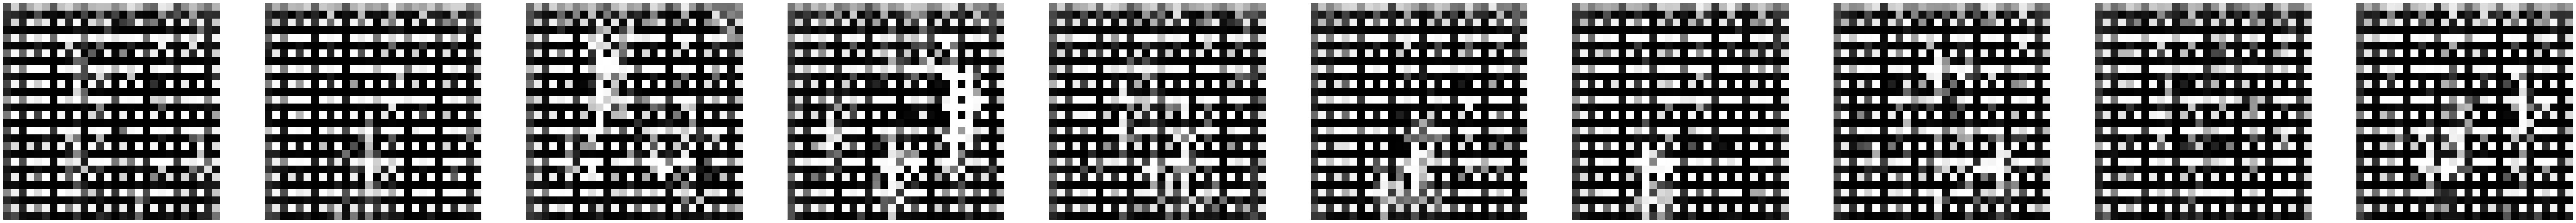

Epoch 4/50


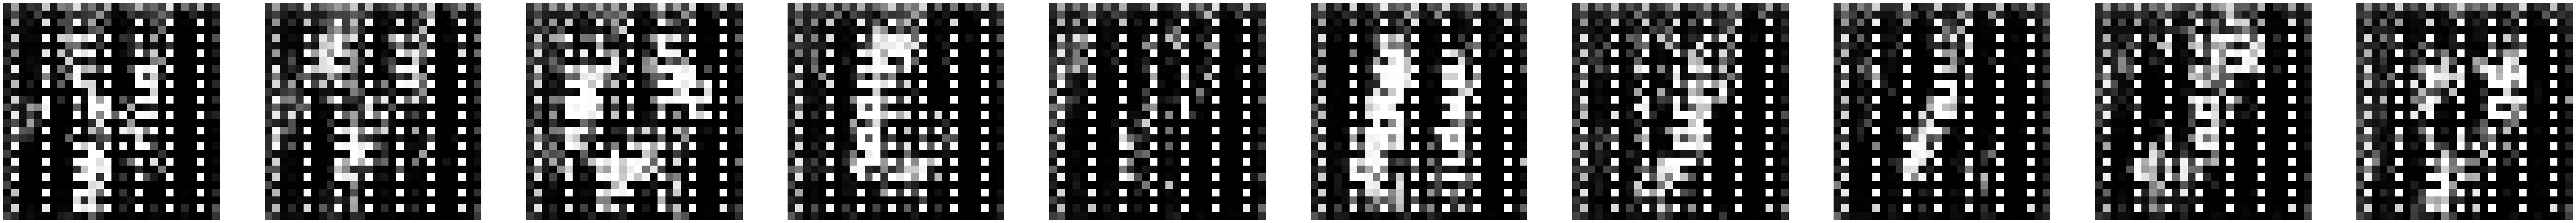

Epoch 5/50


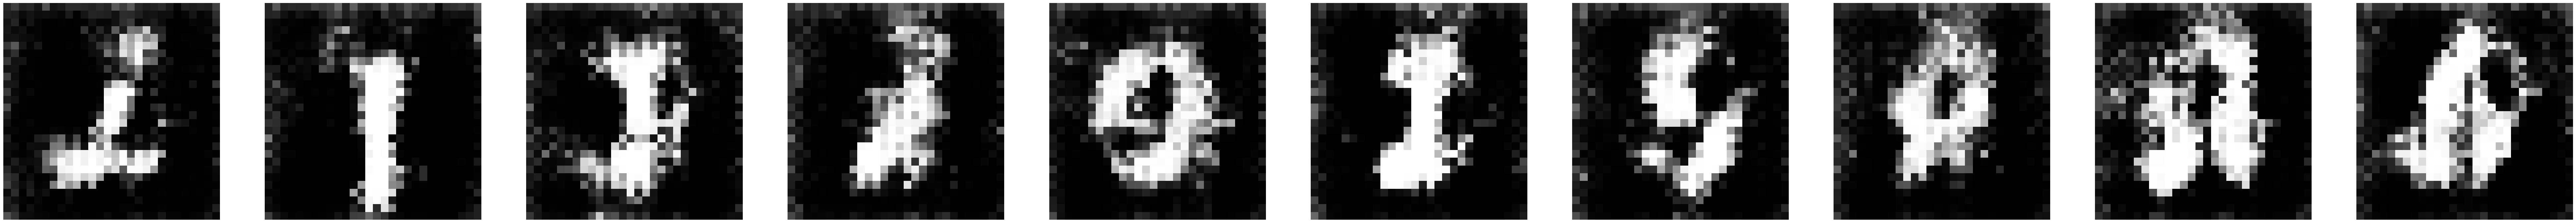

Epoch 6/50


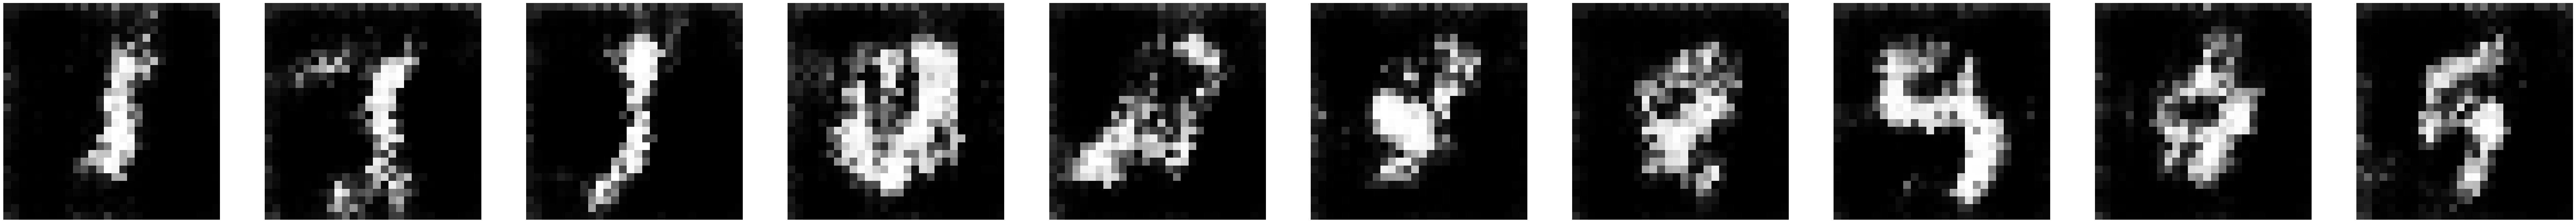

Epoch 7/50


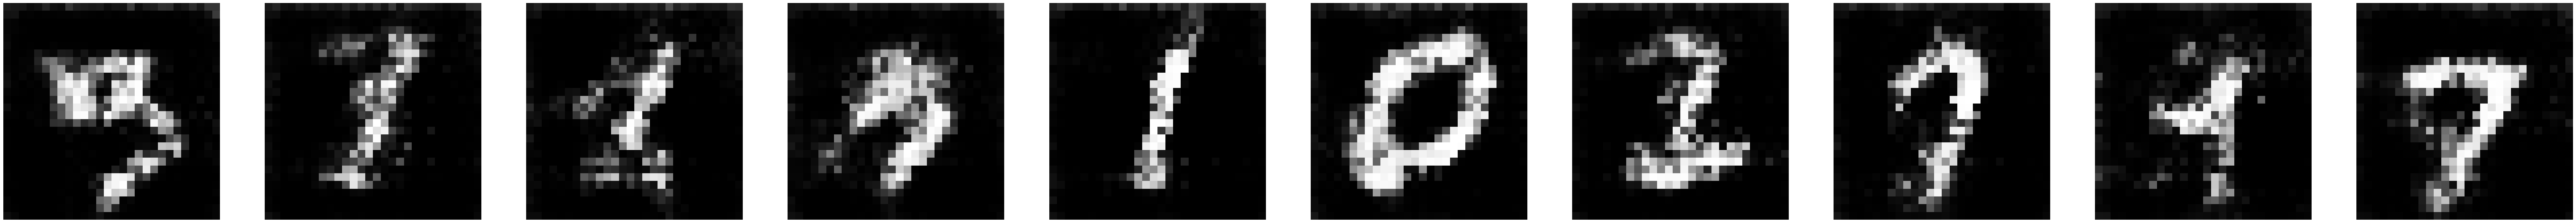

Epoch 8/50


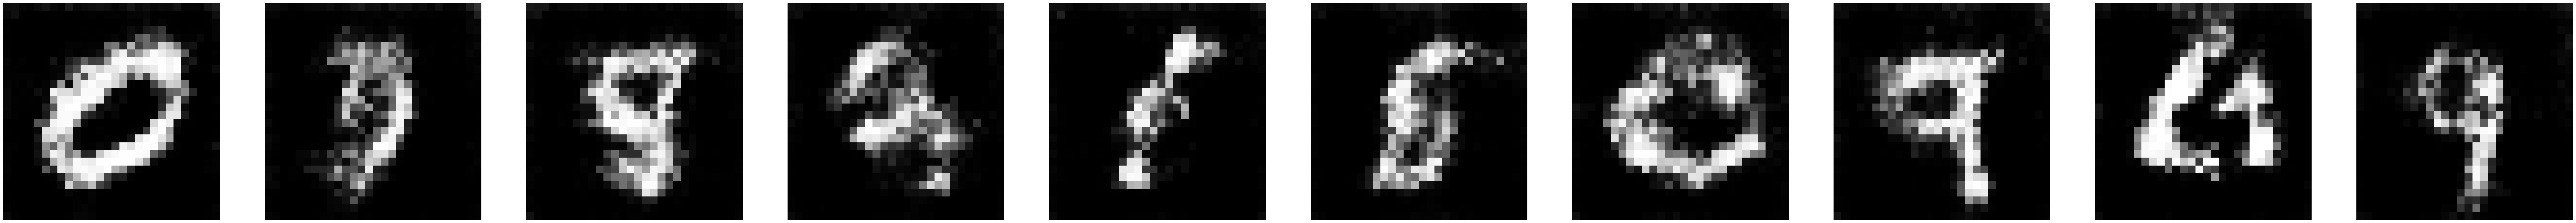

Epoch 9/50


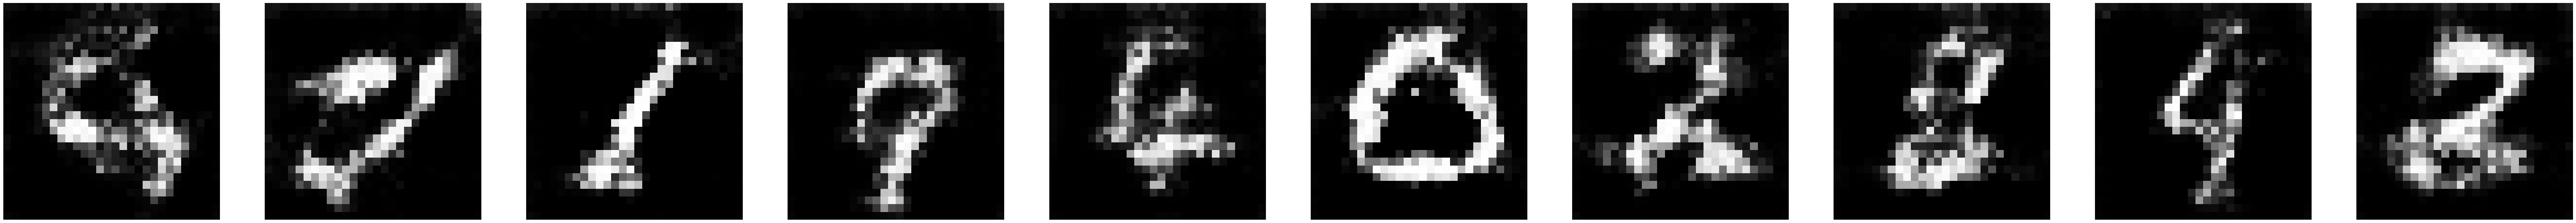

Epoch 10/50


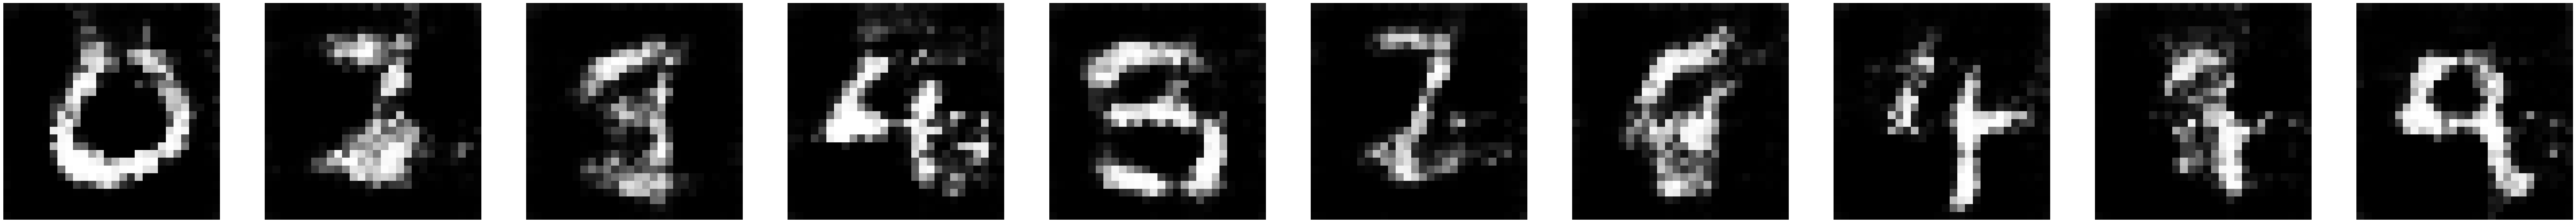

Epoch 11/50


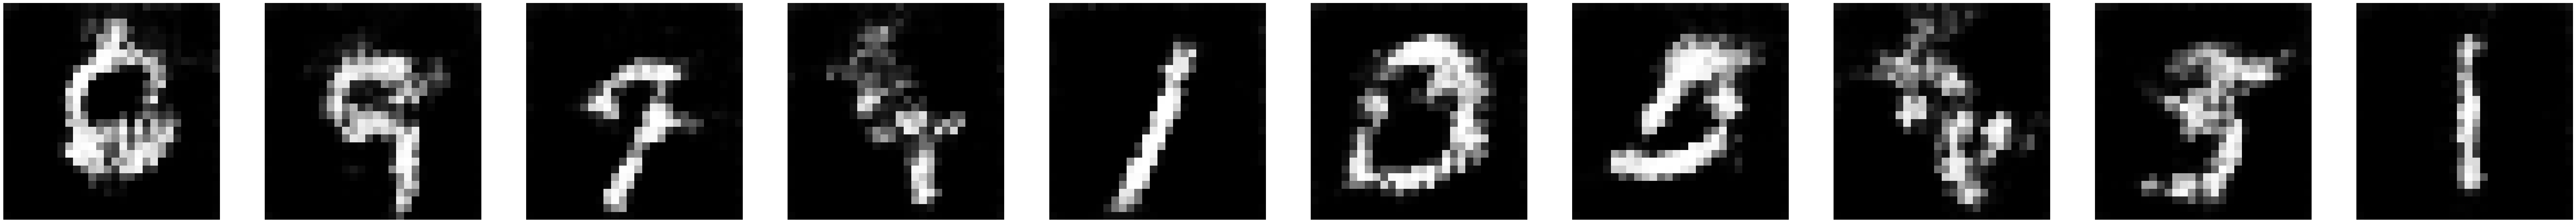

Epoch 12/50


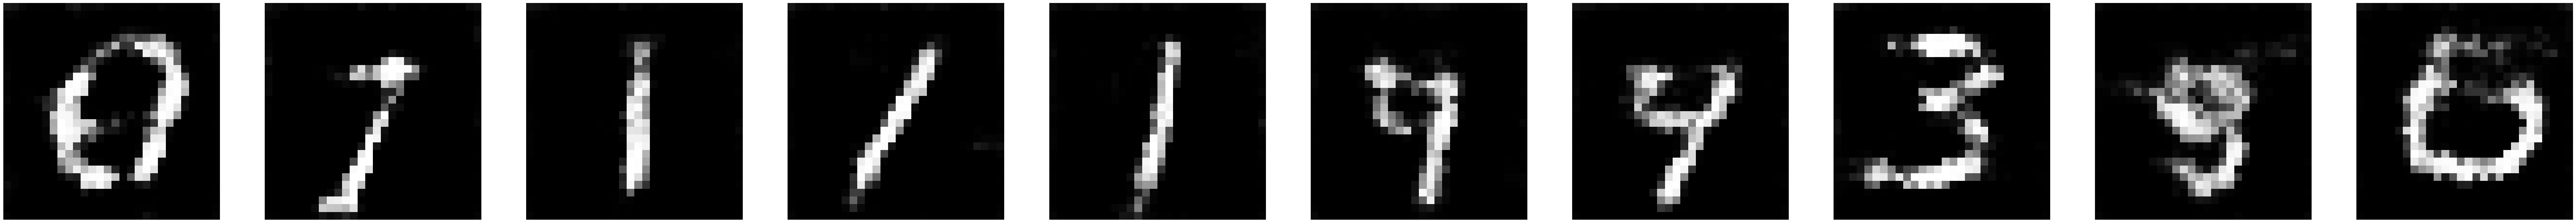

Epoch 13/50


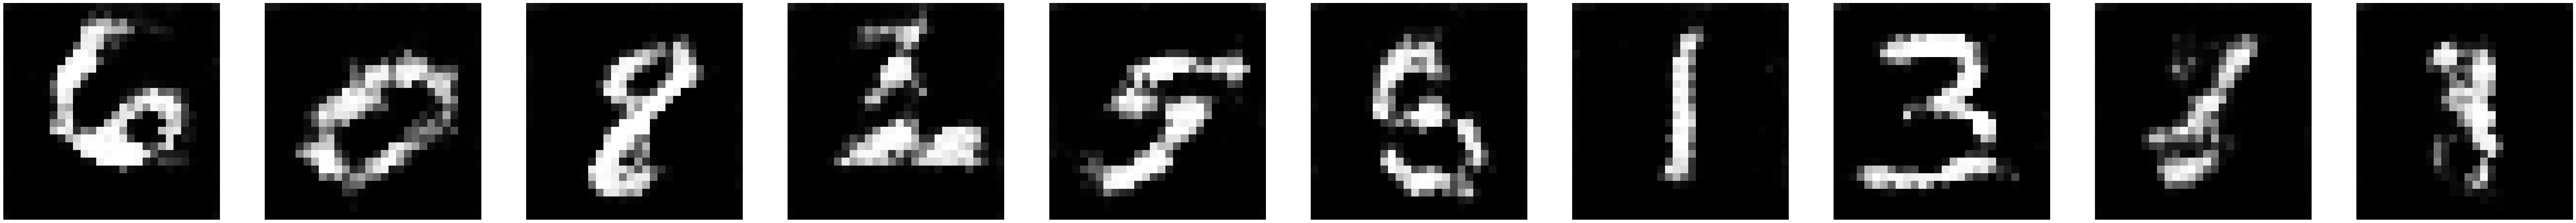

Epoch 14/50


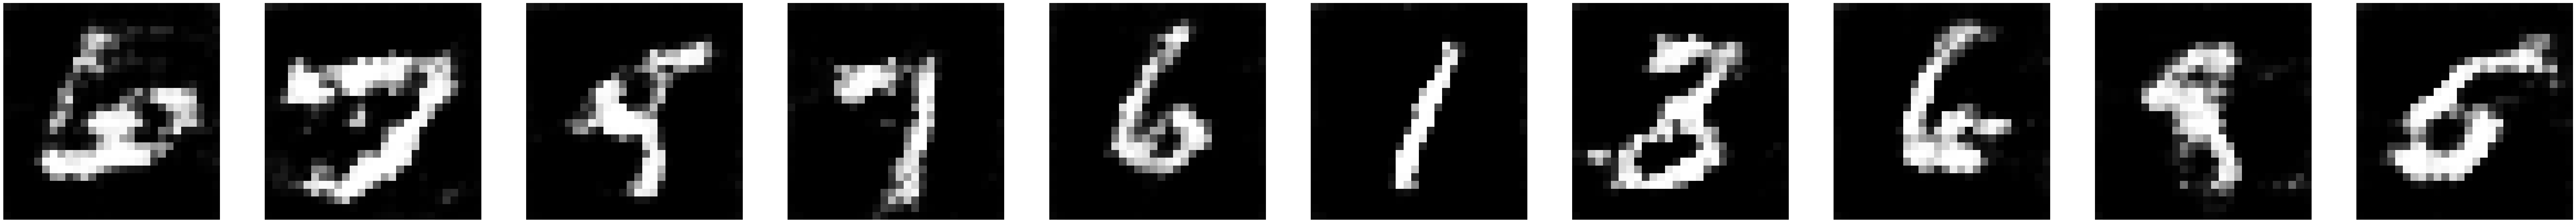

Epoch 15/50


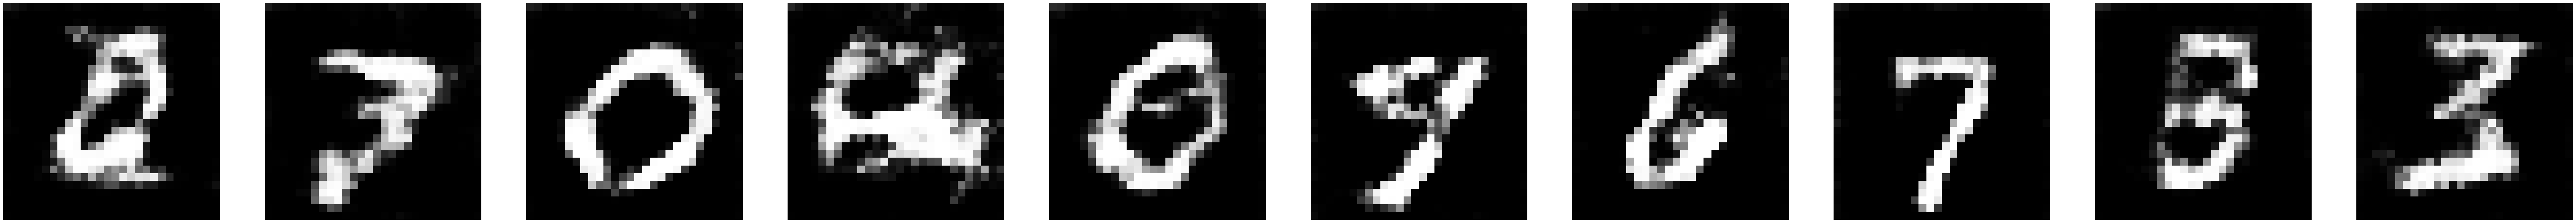

Epoch 16/50


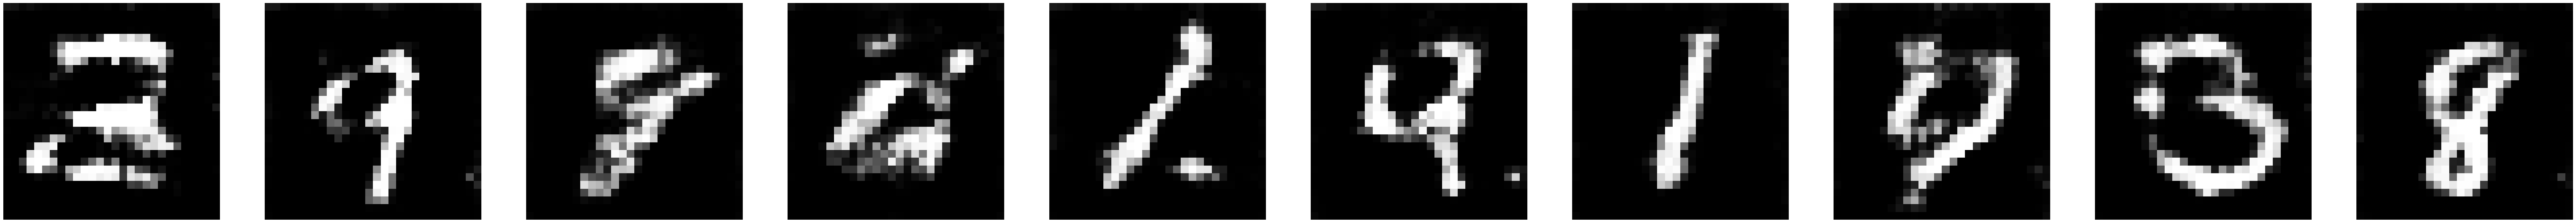

Epoch 17/50


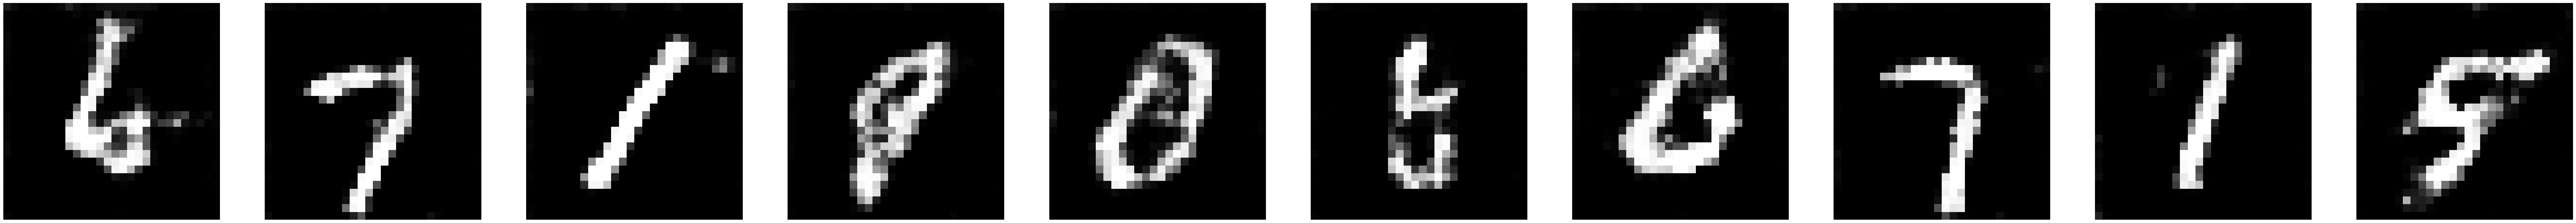

Epoch 18/50


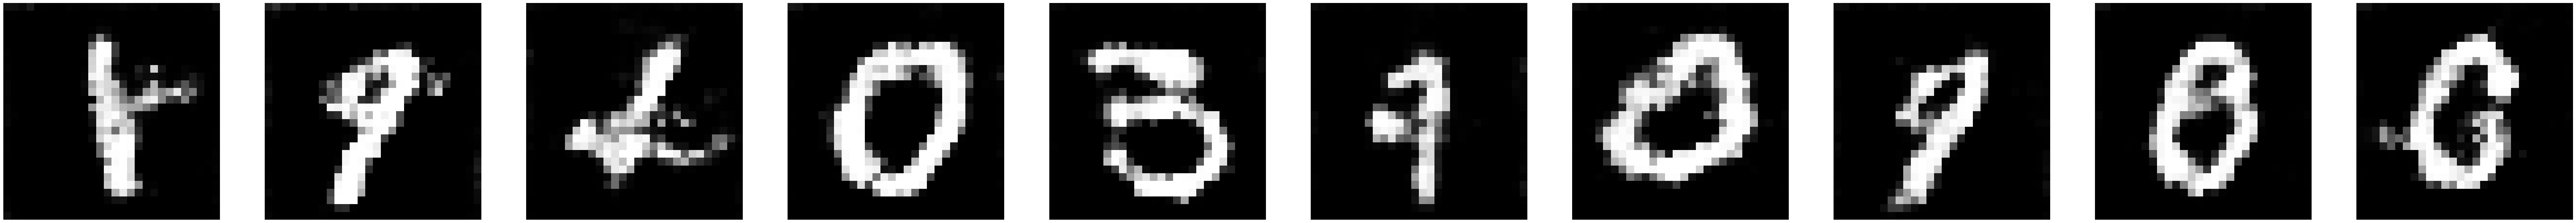

Epoch 19/50


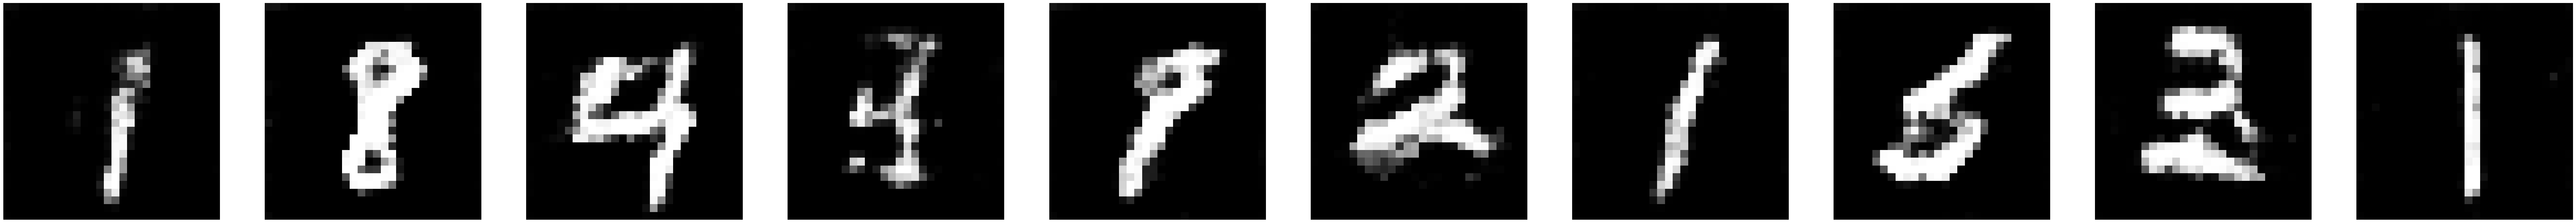

Epoch 20/50


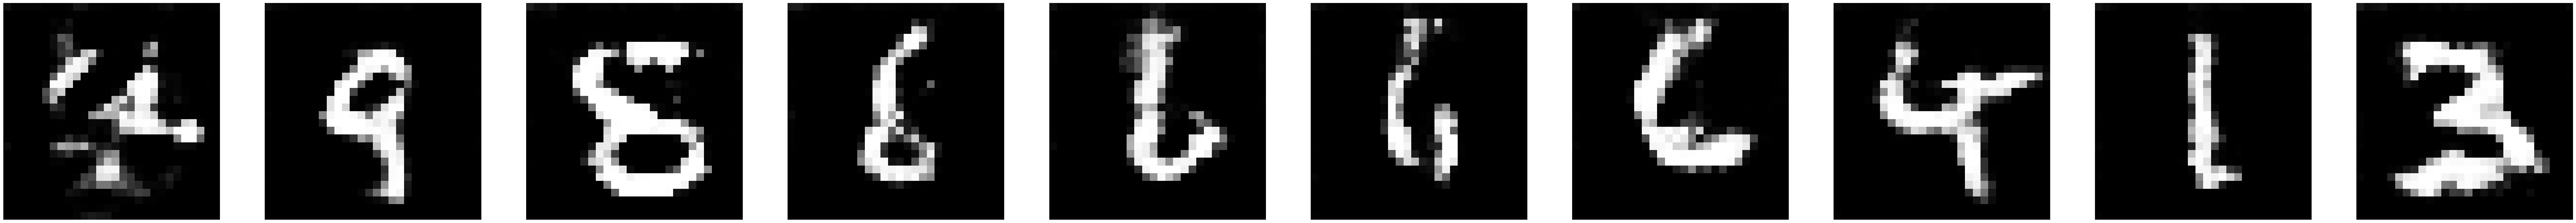

Epoch 21/50


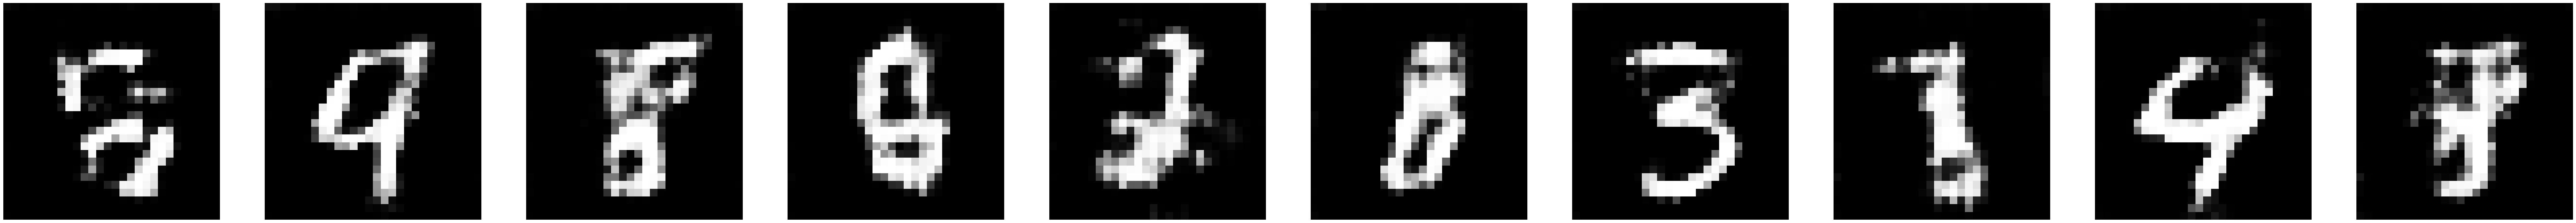

Epoch 22/50


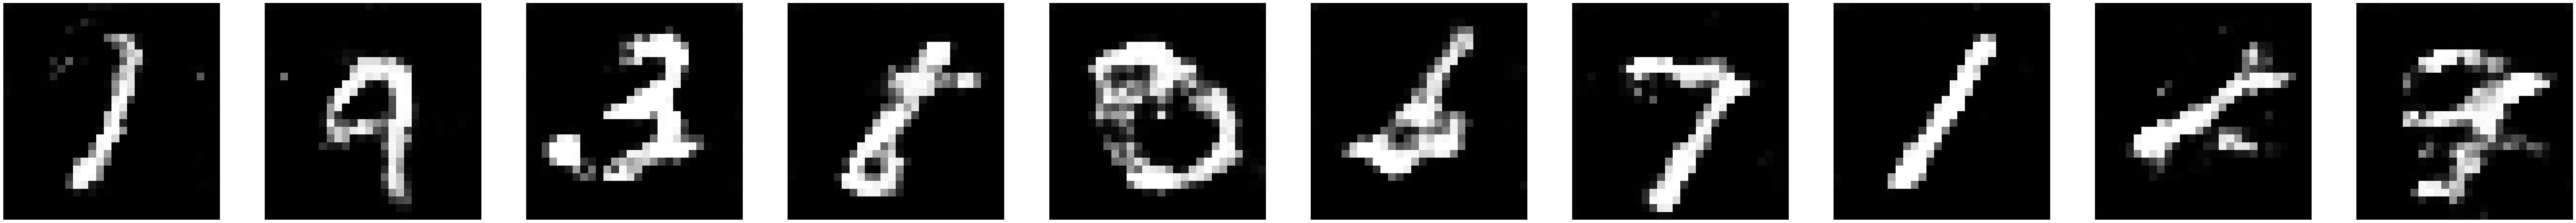

Epoch 23/50


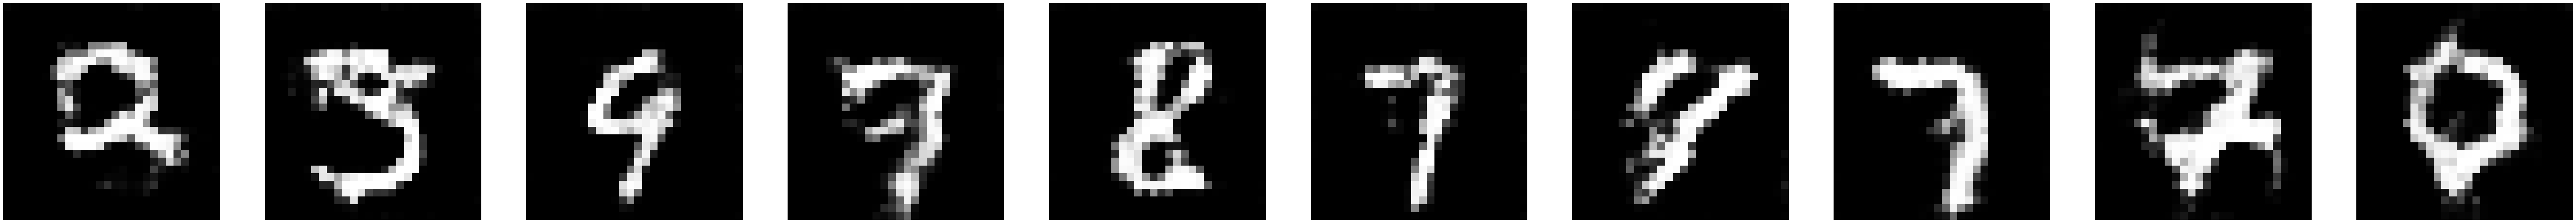

Epoch 24/50


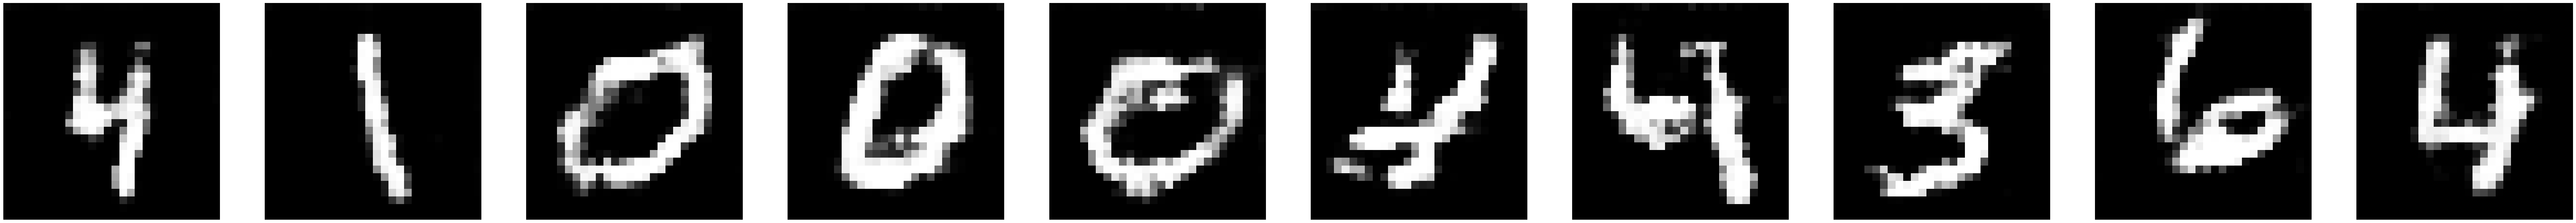

Epoch 25/50


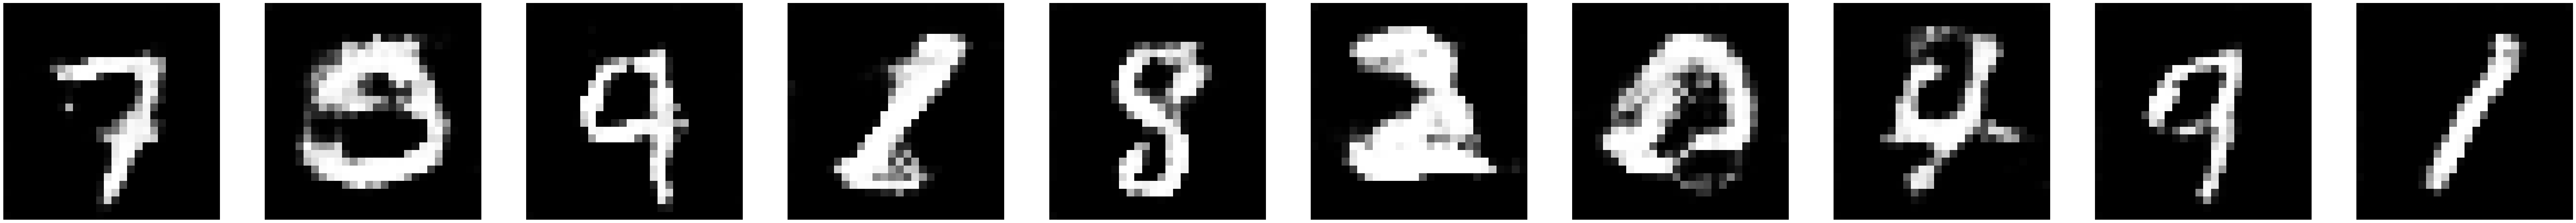

Epoch 26/50


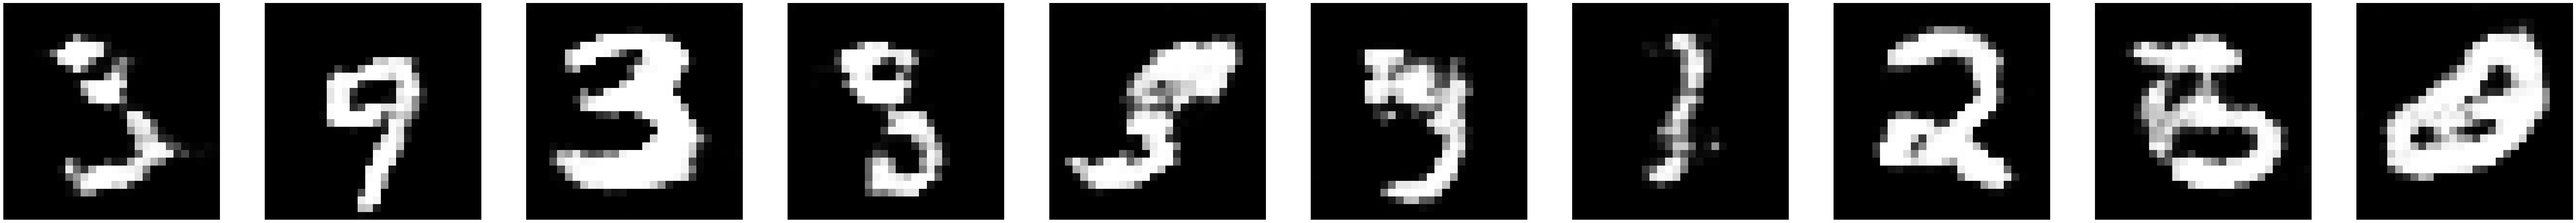

Epoch 27/50


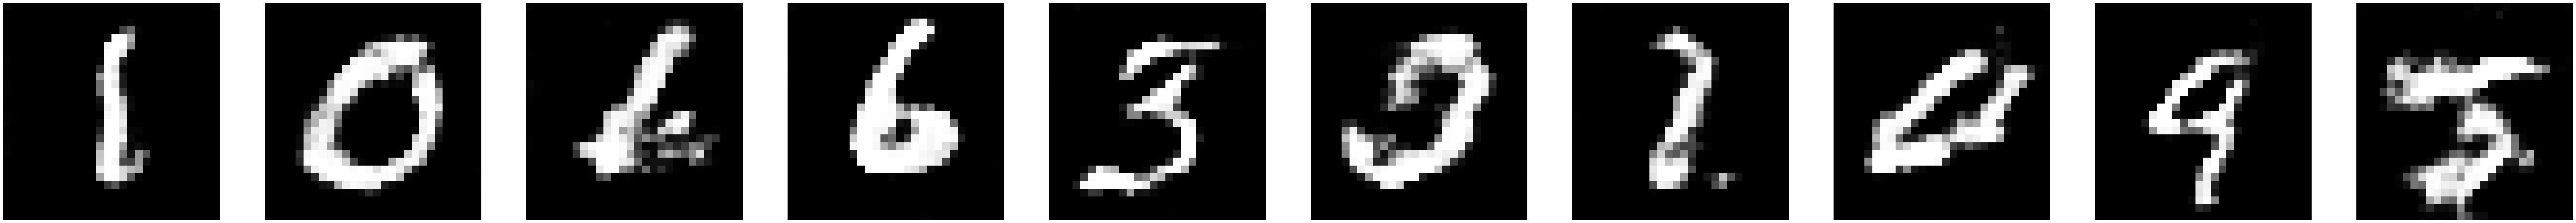

Epoch 28/50


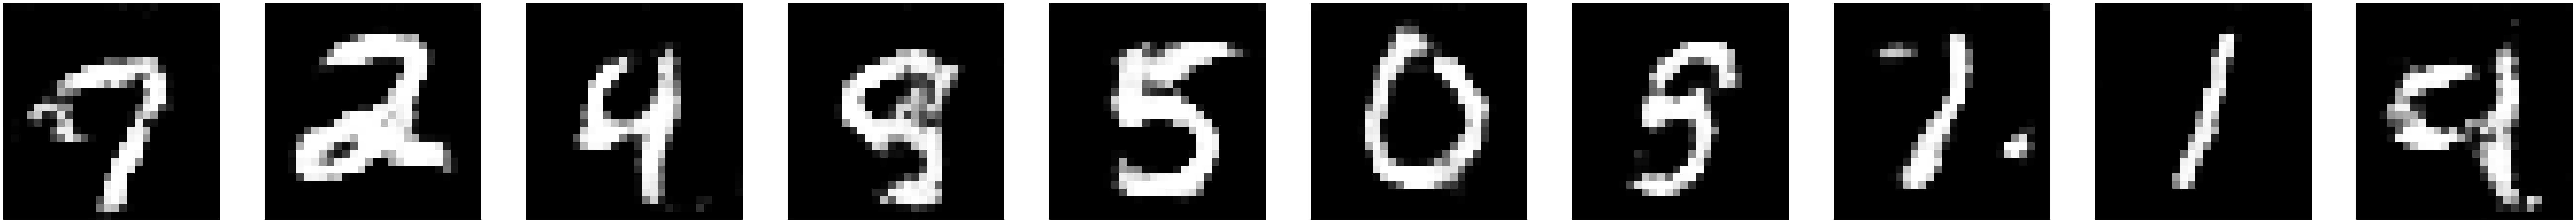

Epoch 29/50


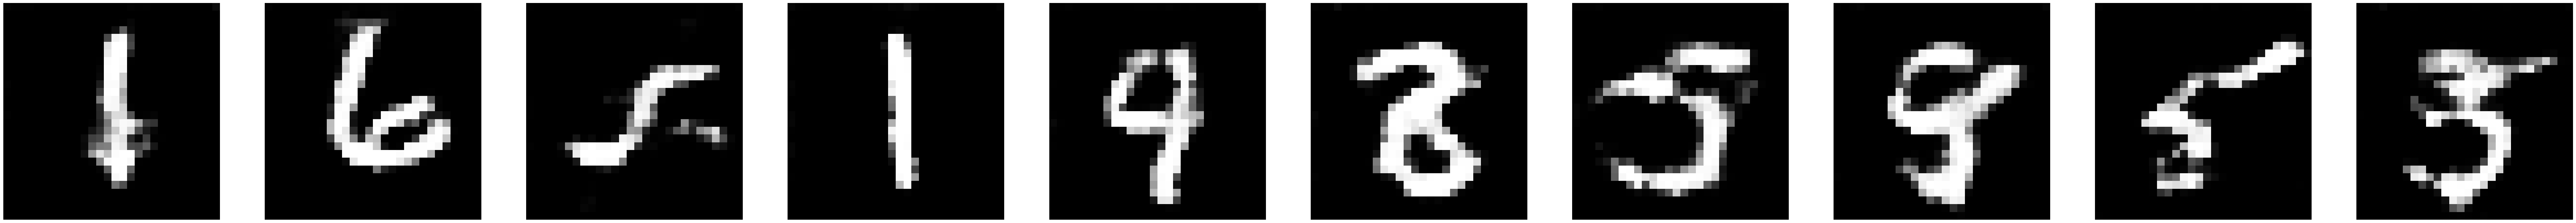

Epoch 30/50


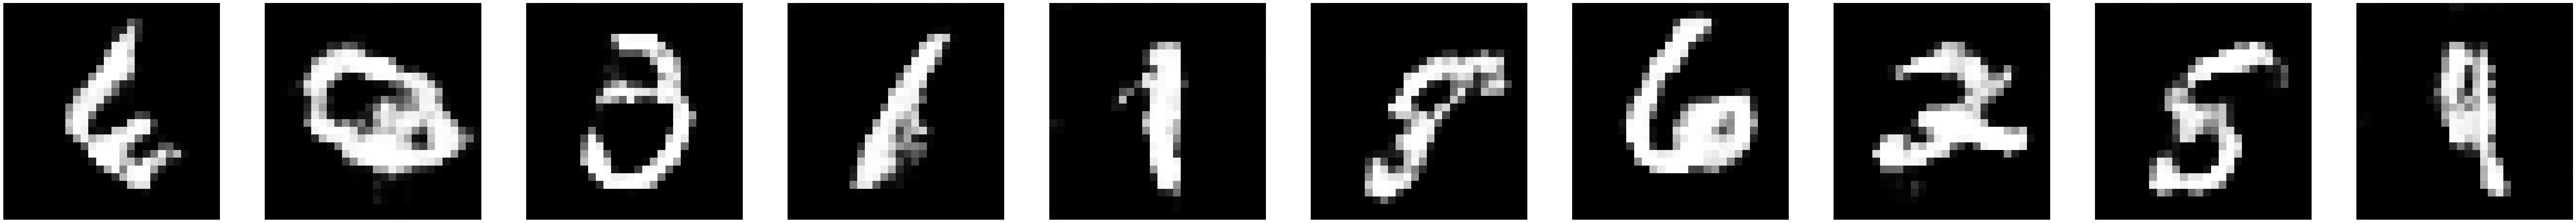

Epoch 31/50


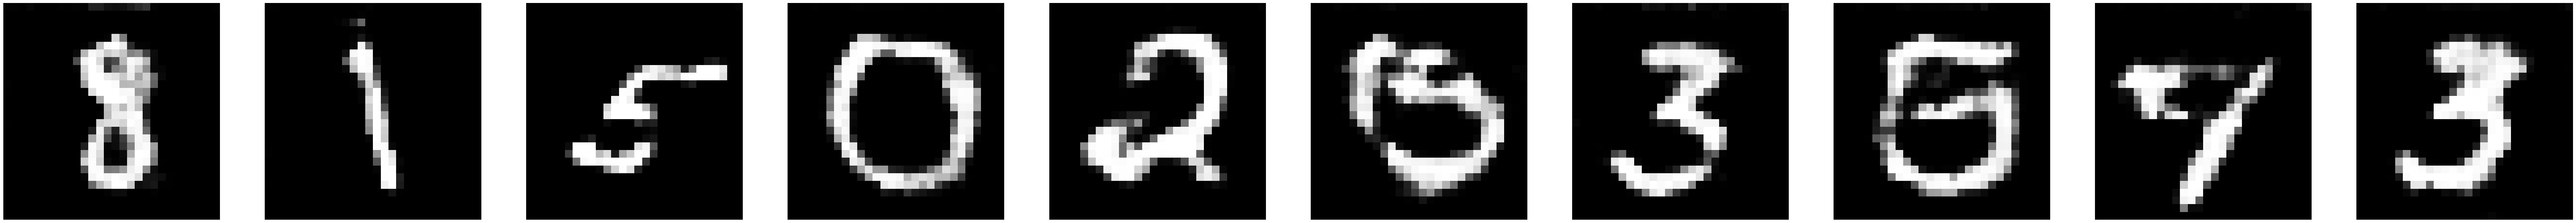

Epoch 32/50


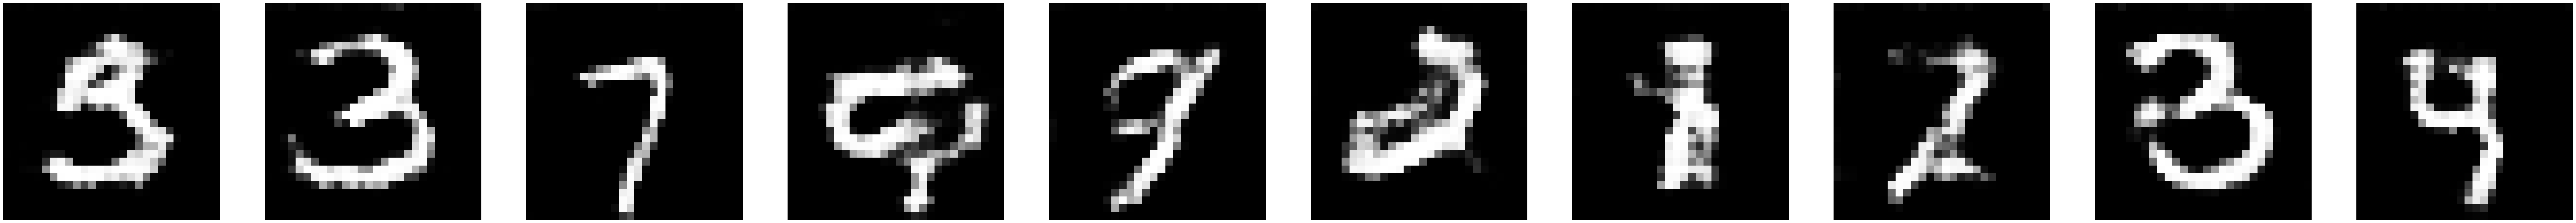

Epoch 33/50


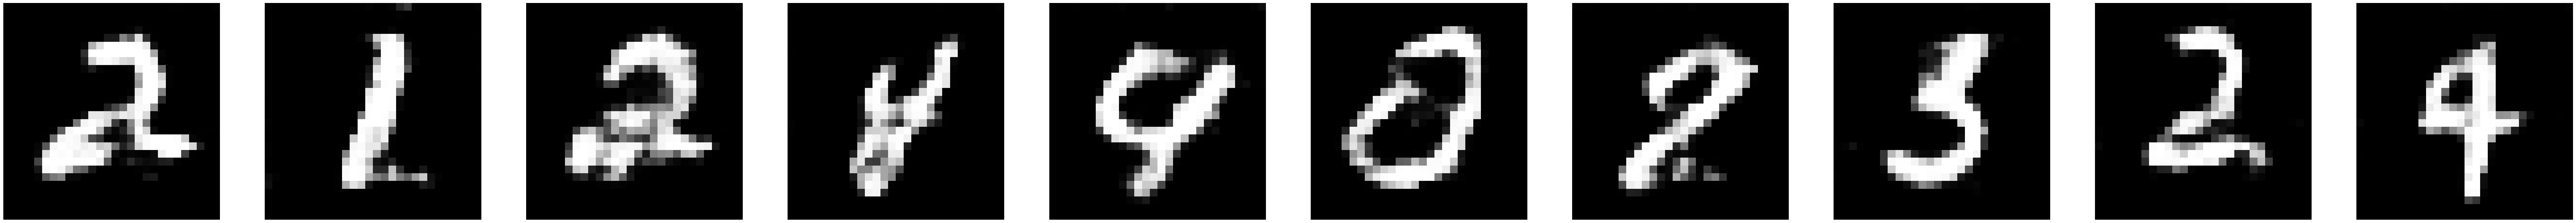

Epoch 34/50


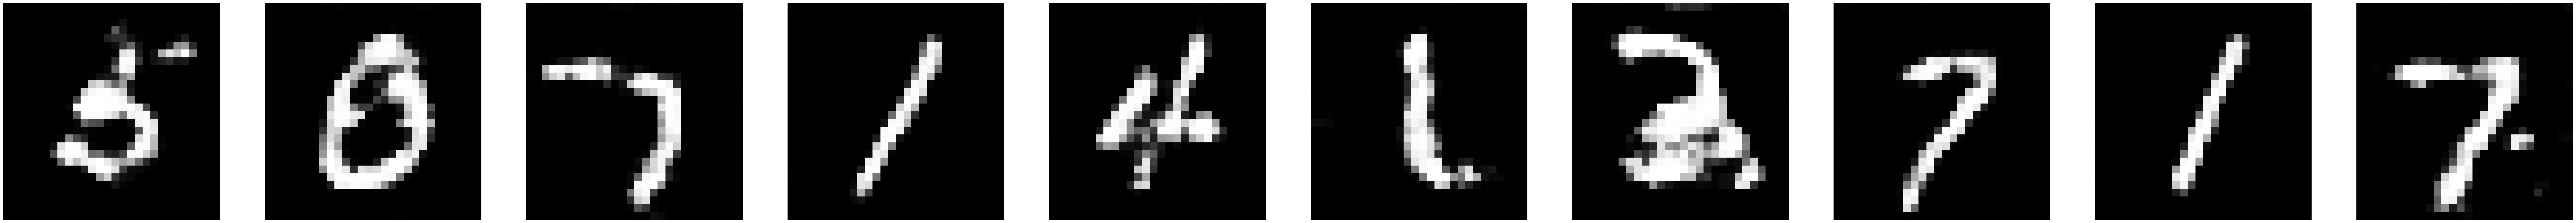

Epoch 35/50


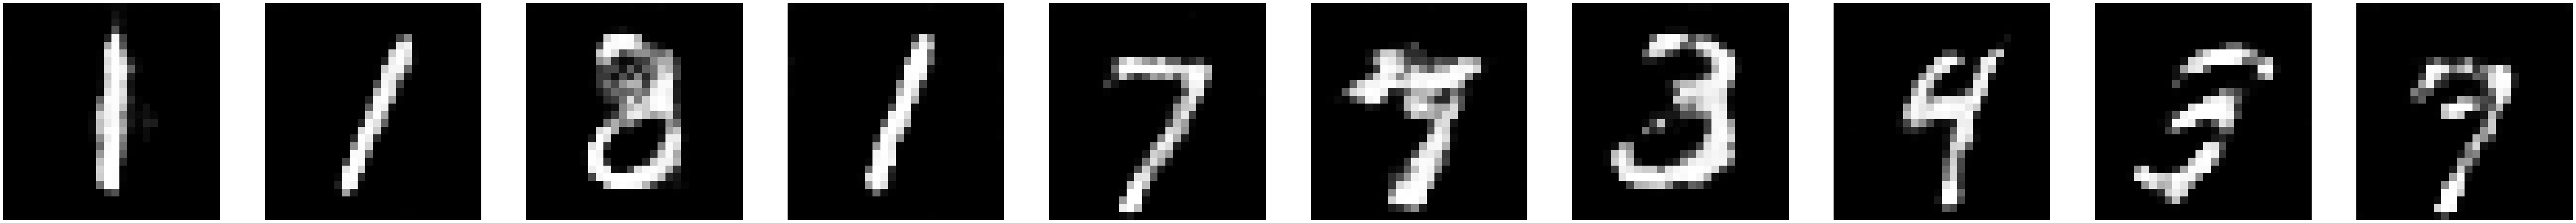

Epoch 36/50


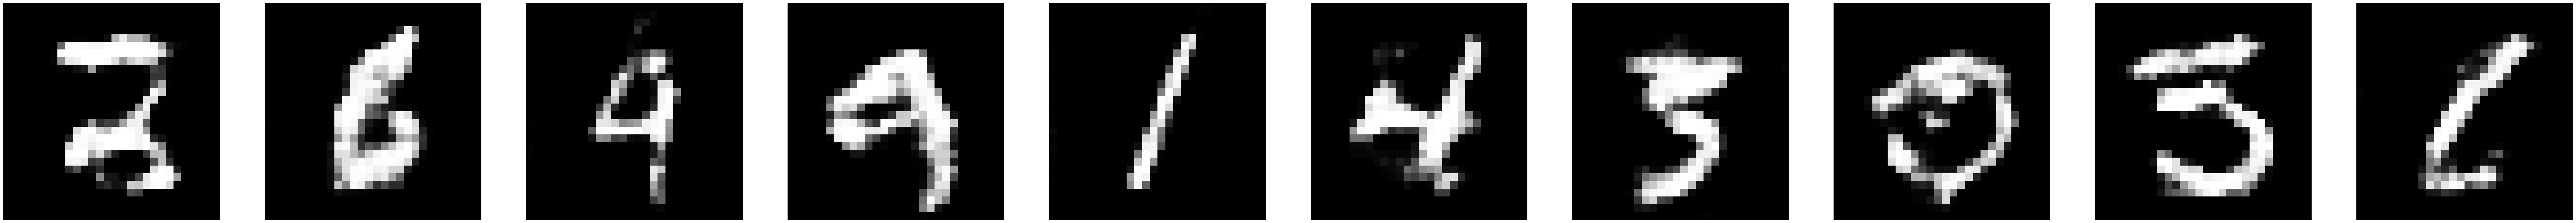

Epoch 37/50


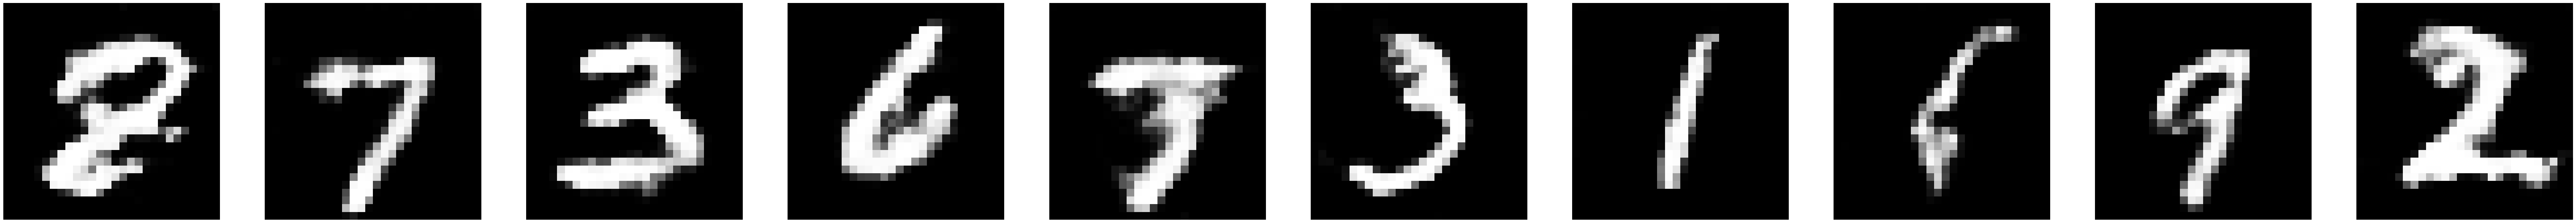

Epoch 38/50


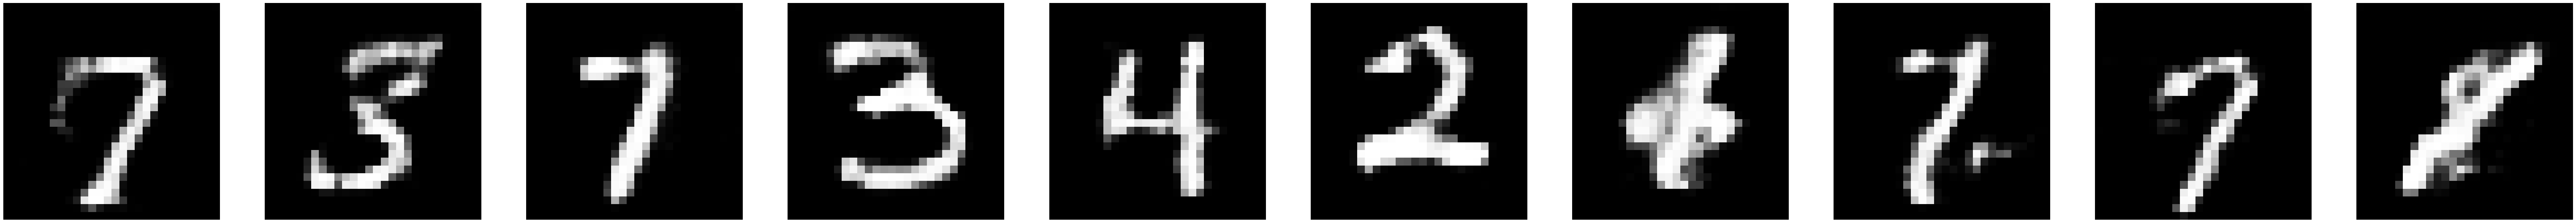

Epoch 39/50


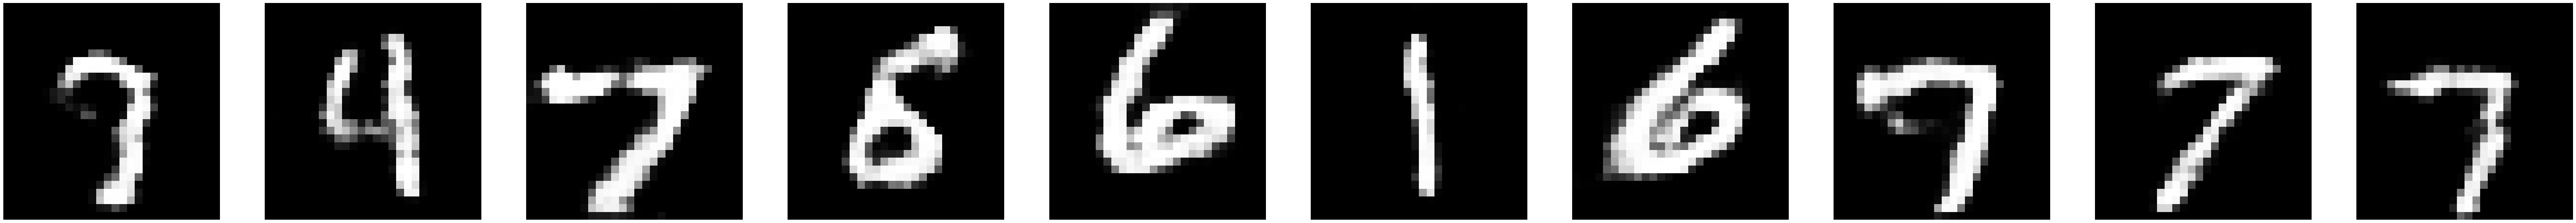

Epoch 40/50


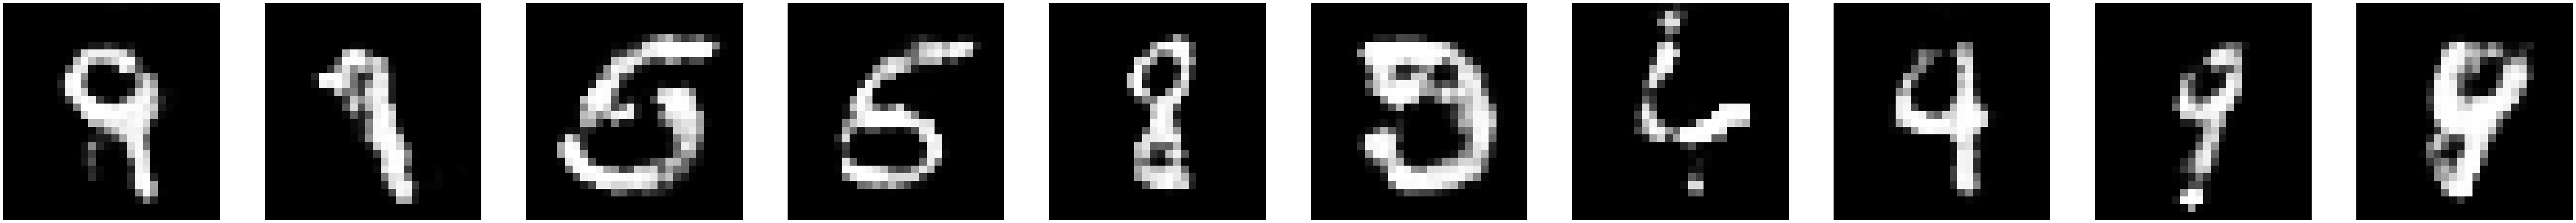

Epoch 41/50


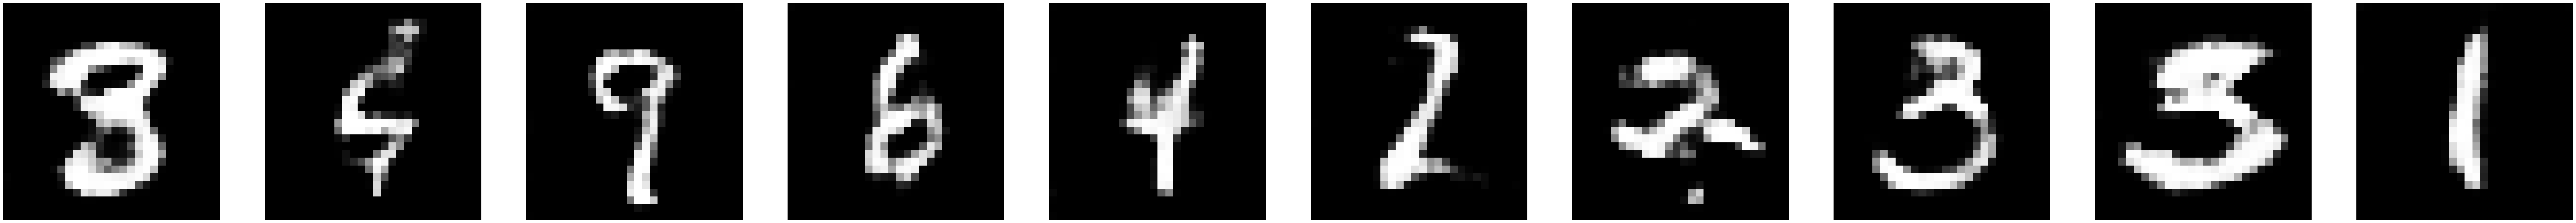

Epoch 42/50


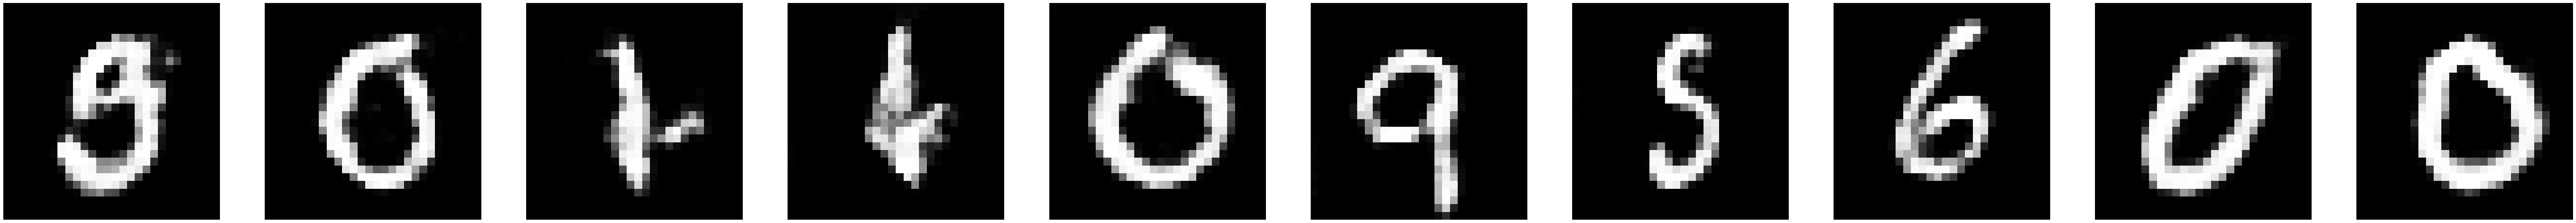

Epoch 43/50


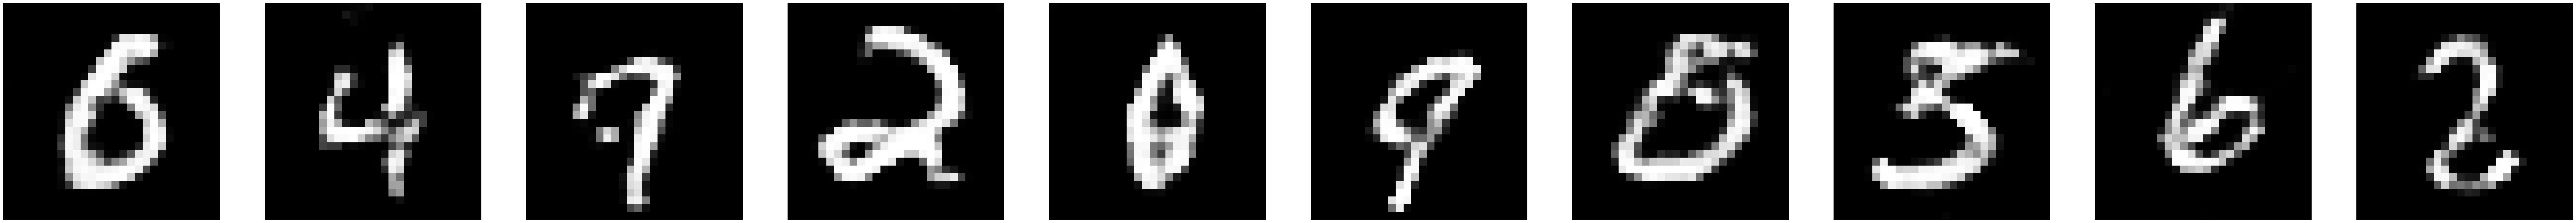

Epoch 44/50


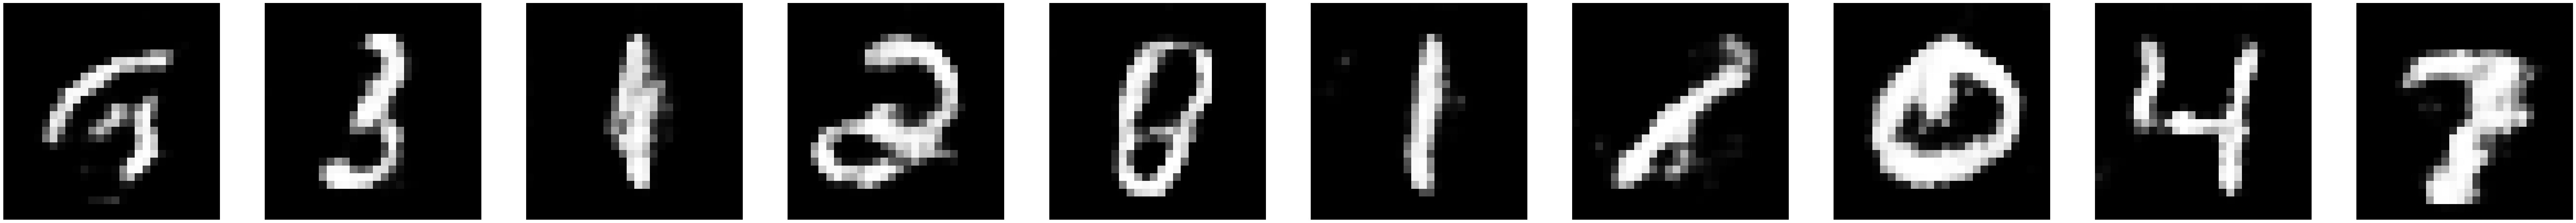

Epoch 45/50


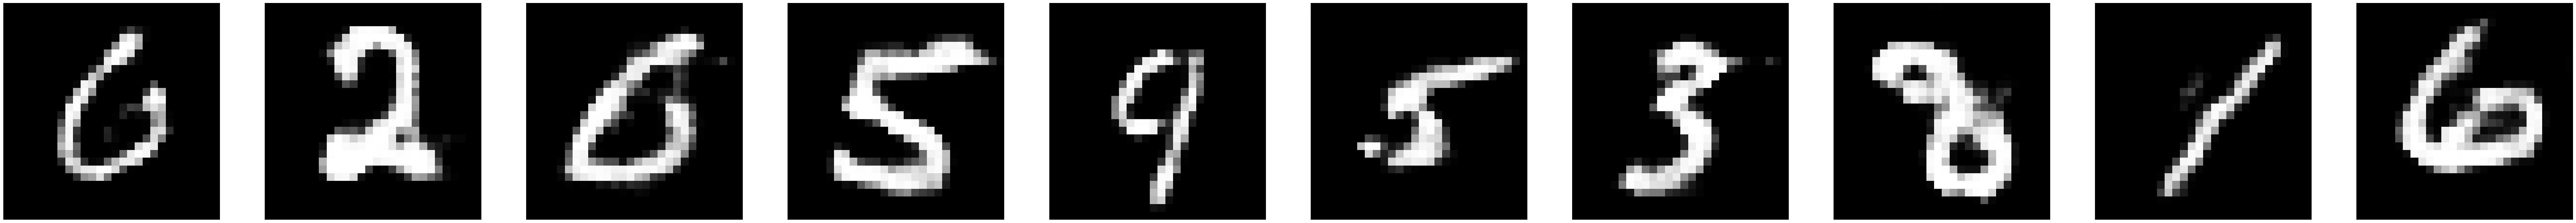

Epoch 46/50


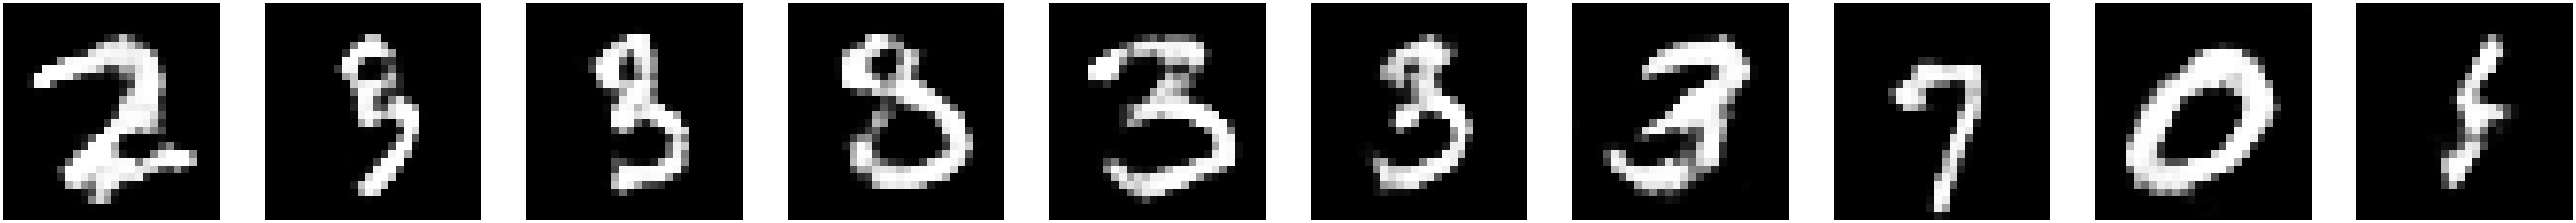

Epoch 47/50


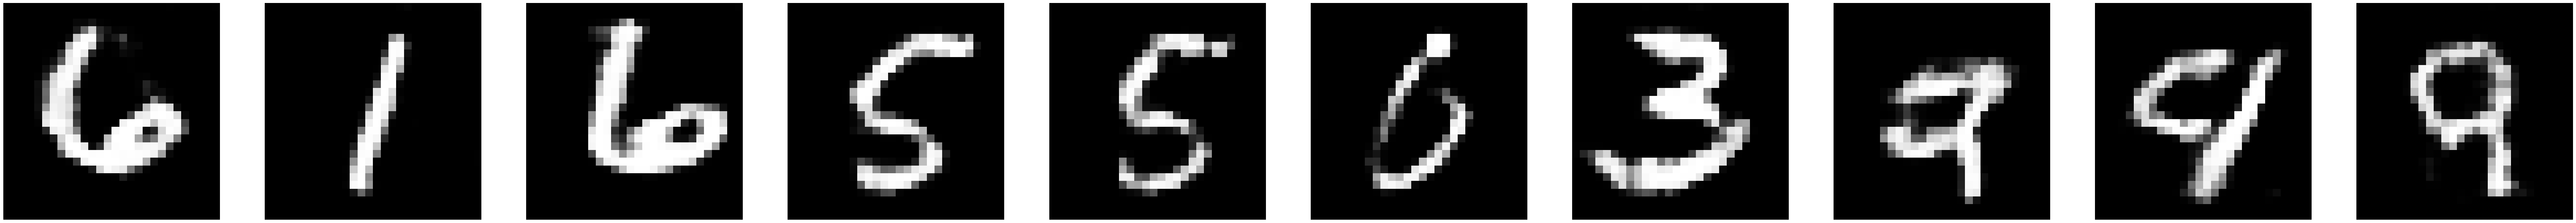

Epoch 48/50


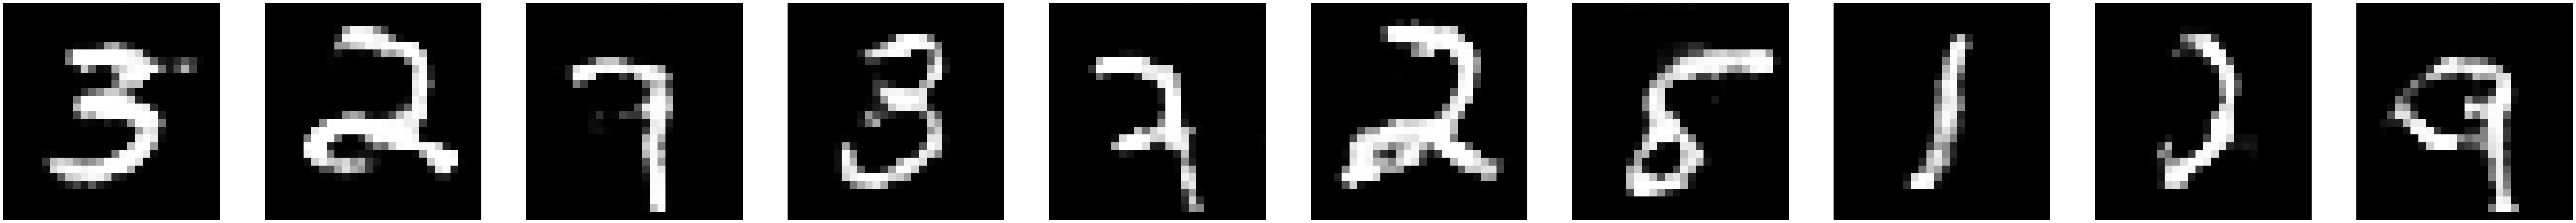

Epoch 49/50


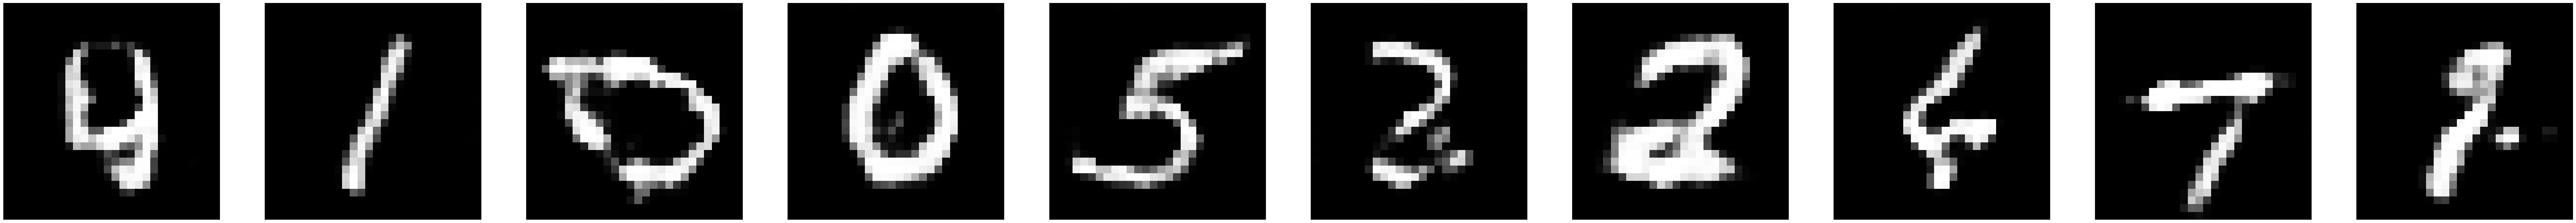

In [17]:

input_distribution_size = 100
learning_rate = 1e-4
batch_size = 256
num_epochs = 50

generator = Generator()
discriminator = Discriminator()
noise = NoiseGenerator(input_distribution_size)
d_optim = tf.optimizers.Adam(learning_rate)
g_optim = tf.optimizers.Adam(learning_rate)

train_step = train_step_template(
    generator=generator,
    discriminator=discriminator,
    noise=noise,
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_f=min_max_discriminator_loss,
    g_loss_f=min_max_generator_loss,
)

gen_step = gen_step_template(
    generator=generator,
    noise=noise
)

train(
    train_step=train_step,
    gen_step=gen_step,
    batch_size=batch_size,
    epochs=num_epochs
)

# Zadanie 1

Zaimplementuj funkcje straty wg. Wasserstain Loss i przeprowadź analogiczną pętle uczenia co powyżej.

In [18]:
def w_discriminator_loss(real_out, gen_out):
  real_loss = tf.reduce_mean(real_out)
  gen_loss = tf.reduce_mean(gen_out)
  return real_loss - gen_loss

def w_generator_loss(gen_out):
  return tf.reduce_mean(gen_out)

Epoch 0/50


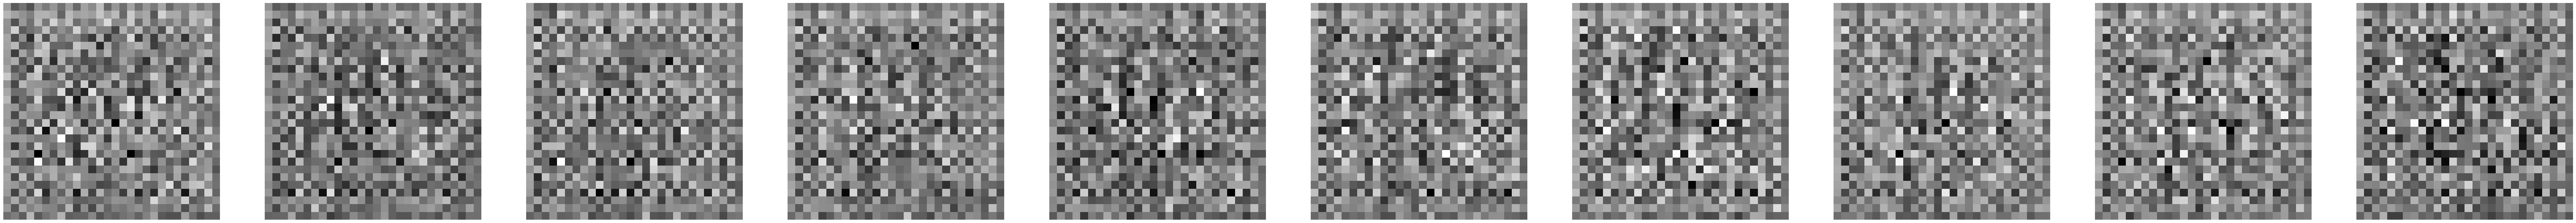

Epoch 1/50


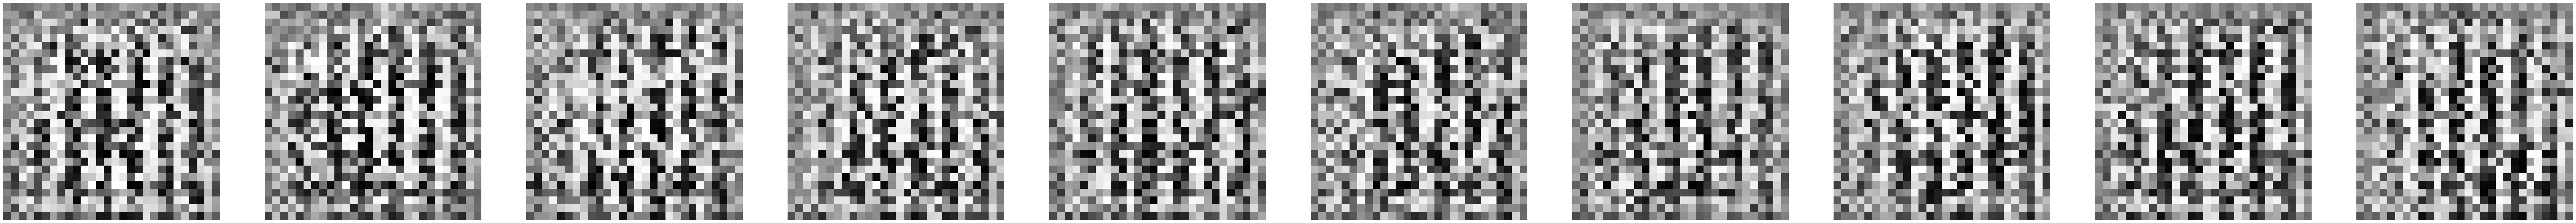

Epoch 2/50


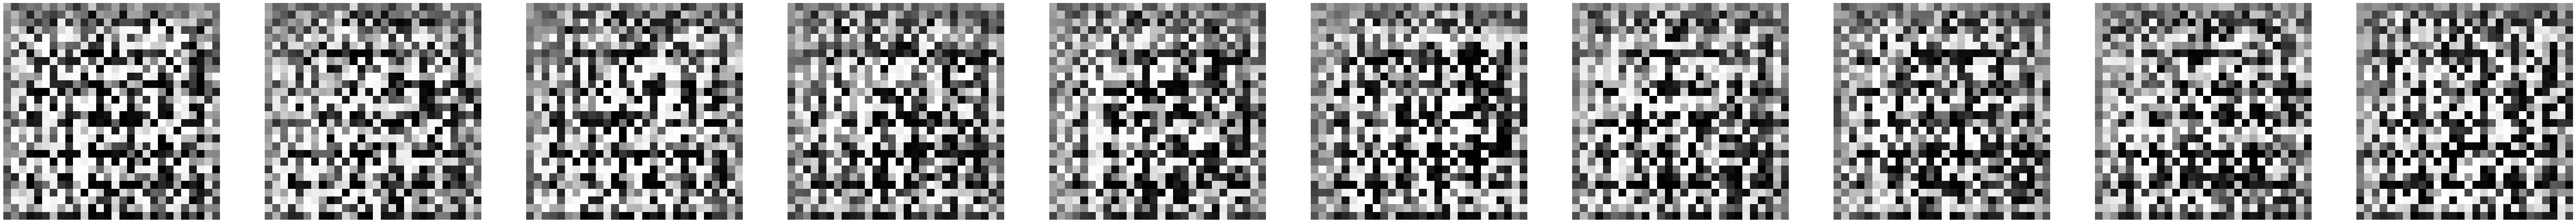

Epoch 3/50


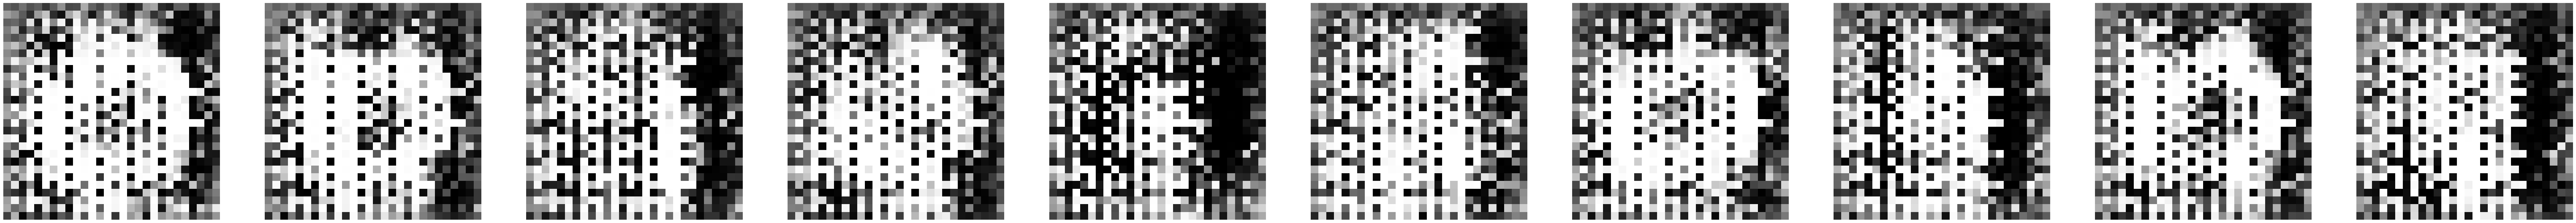

Epoch 4/50


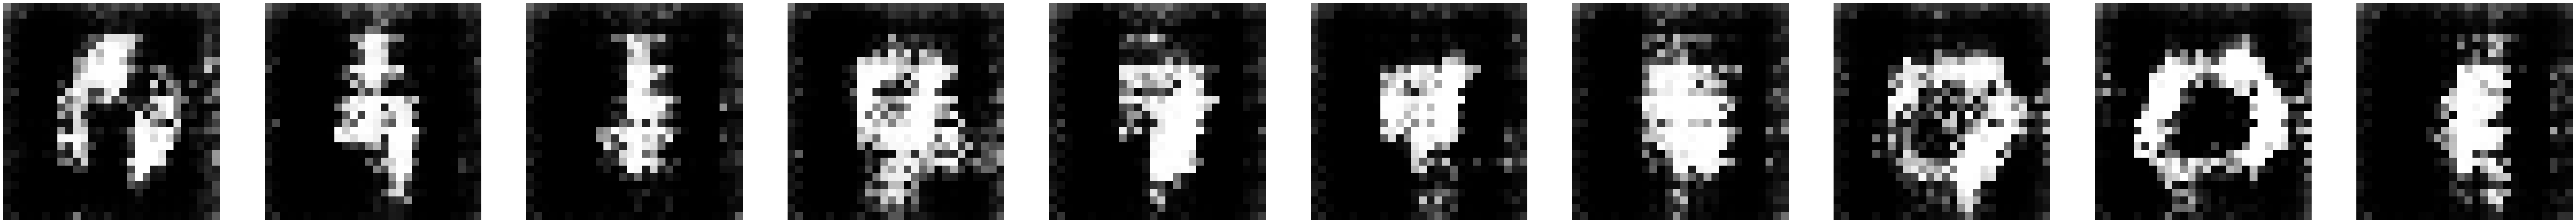

Epoch 5/50


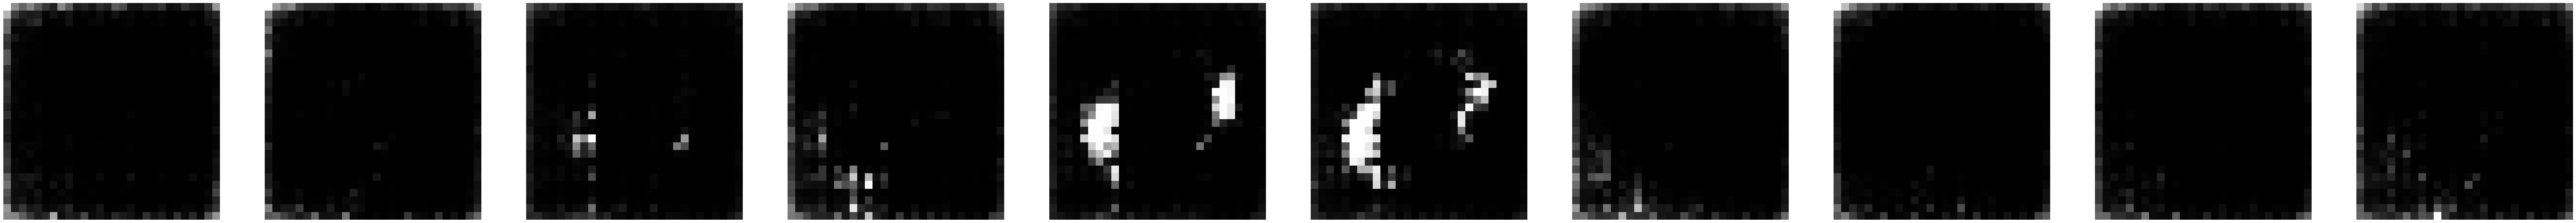

Epoch 6/50


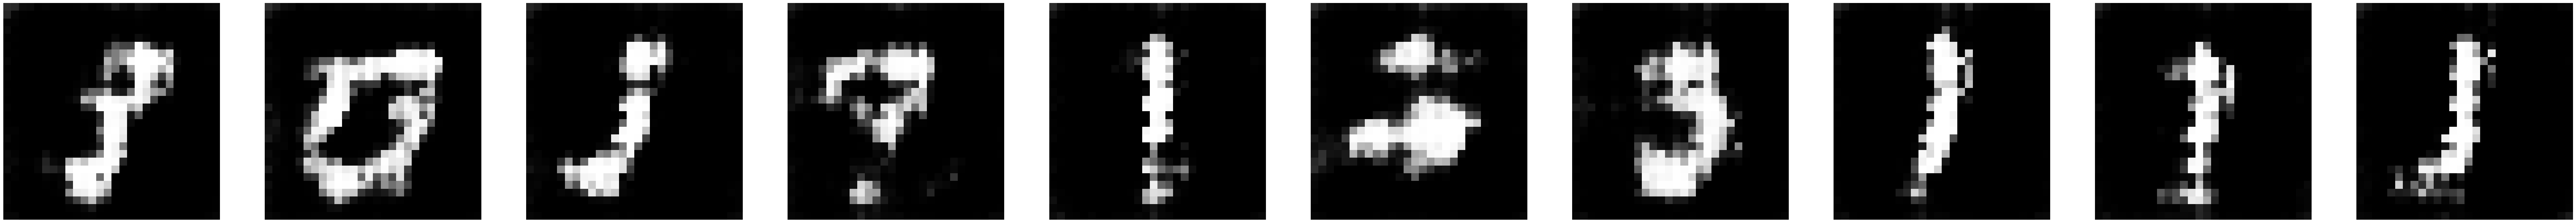

Epoch 7/50


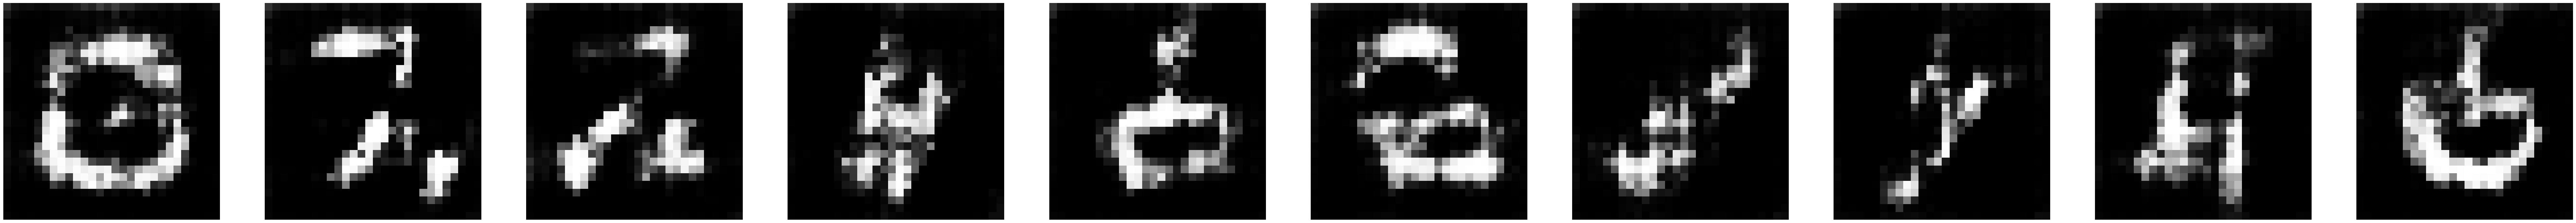

Epoch 8/50


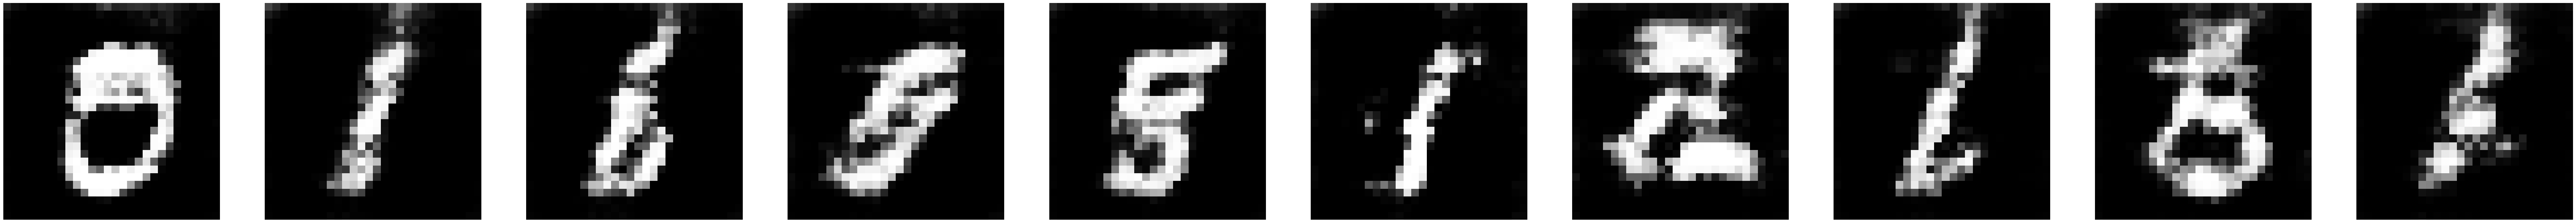

Epoch 9/50


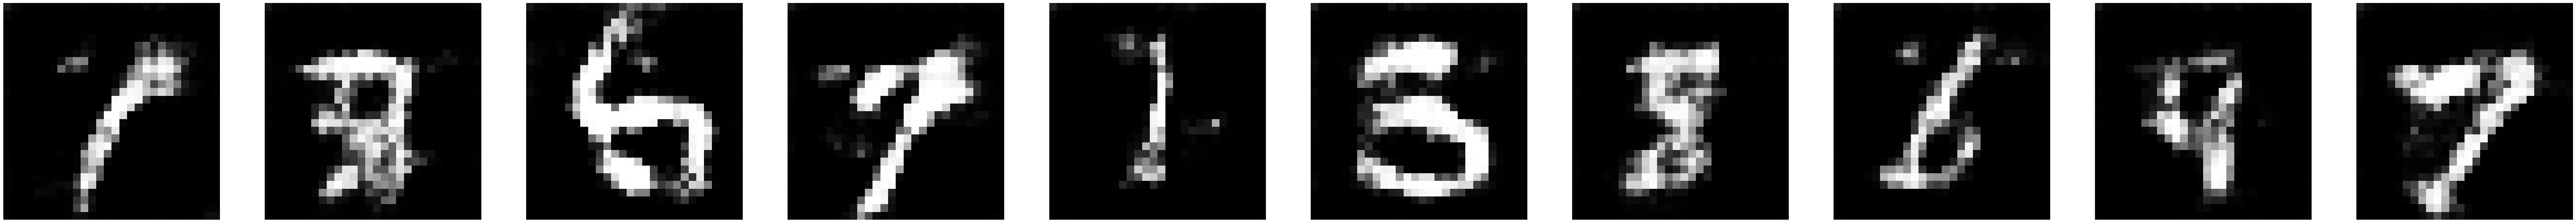

Epoch 10/50


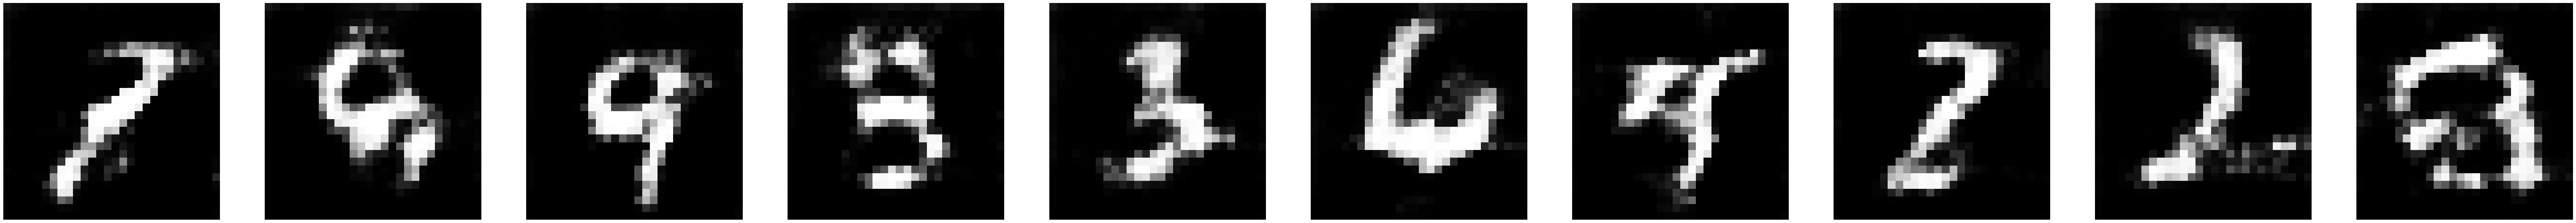

Epoch 11/50


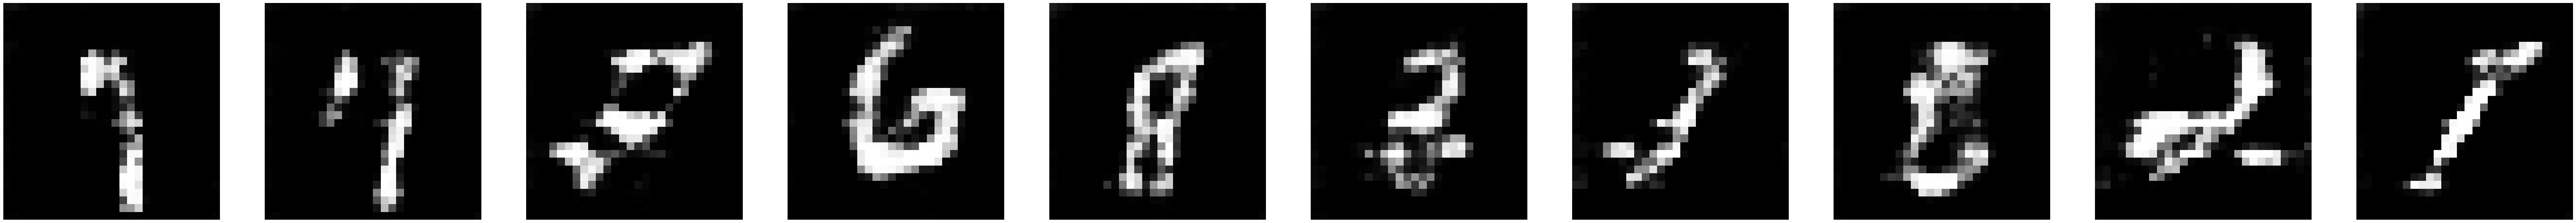

Epoch 12/50


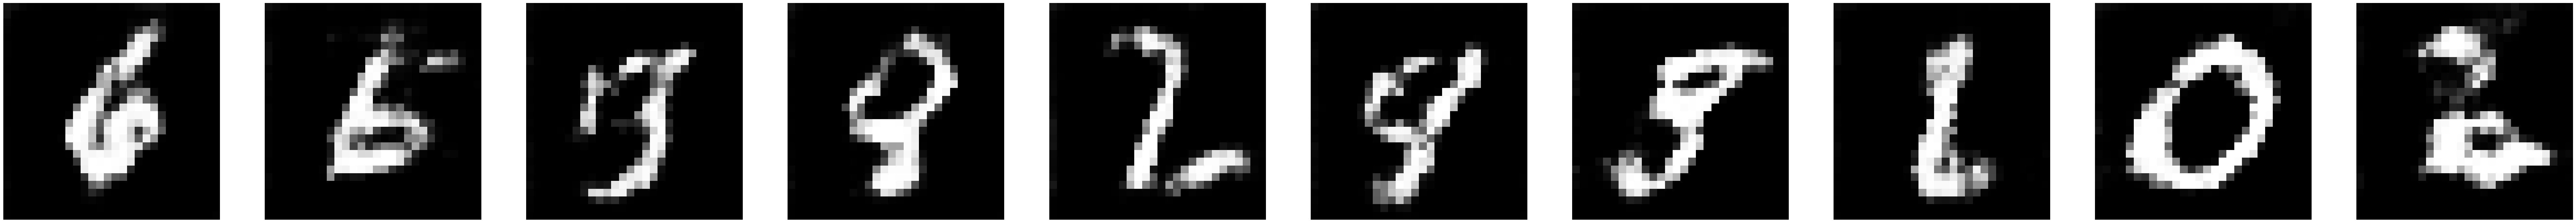

Epoch 13/50


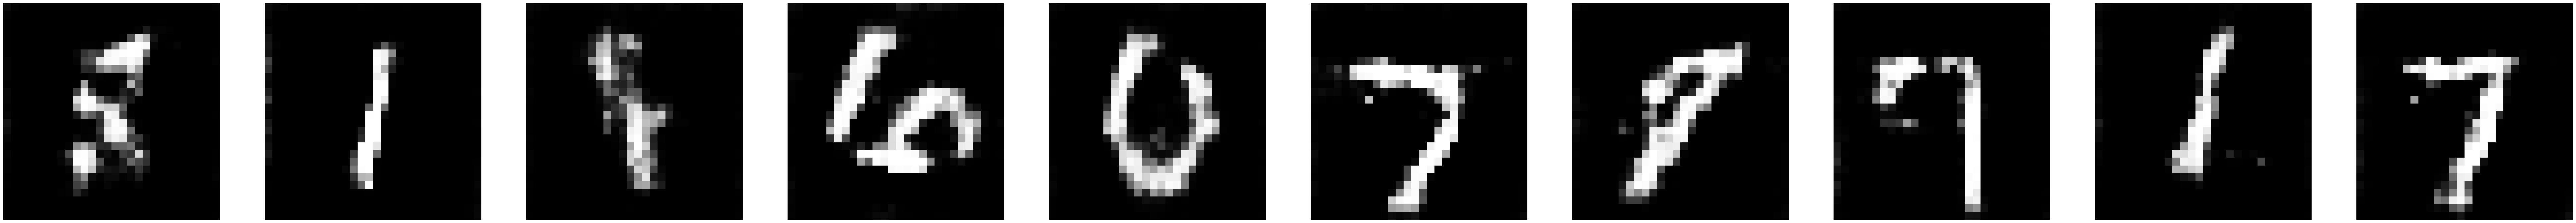

Epoch 14/50


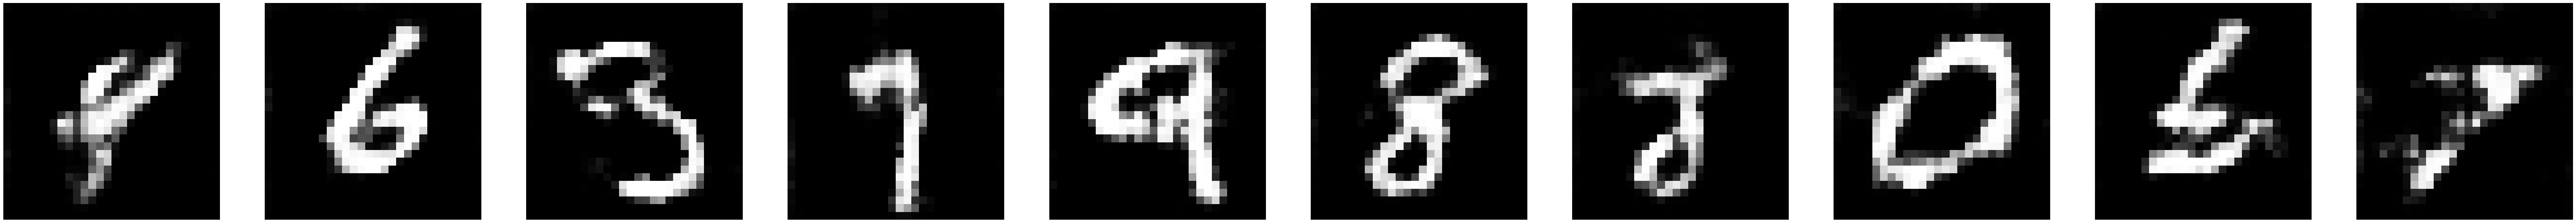

Epoch 15/50


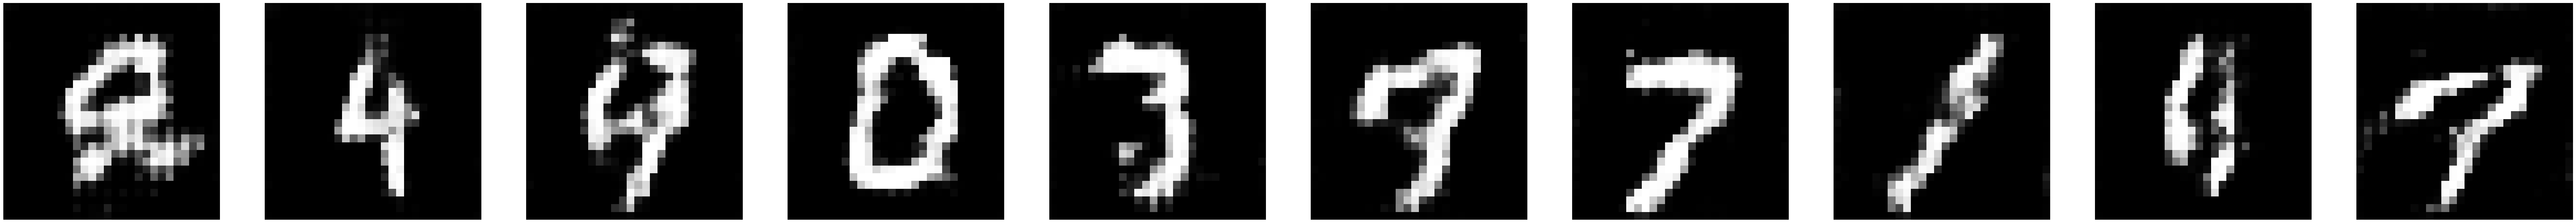

Epoch 16/50


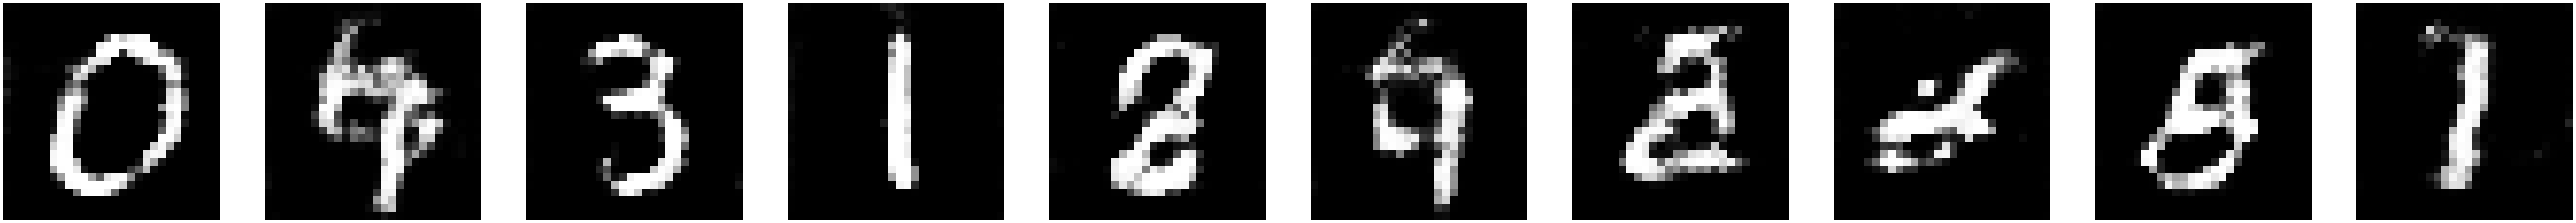

Epoch 17/50


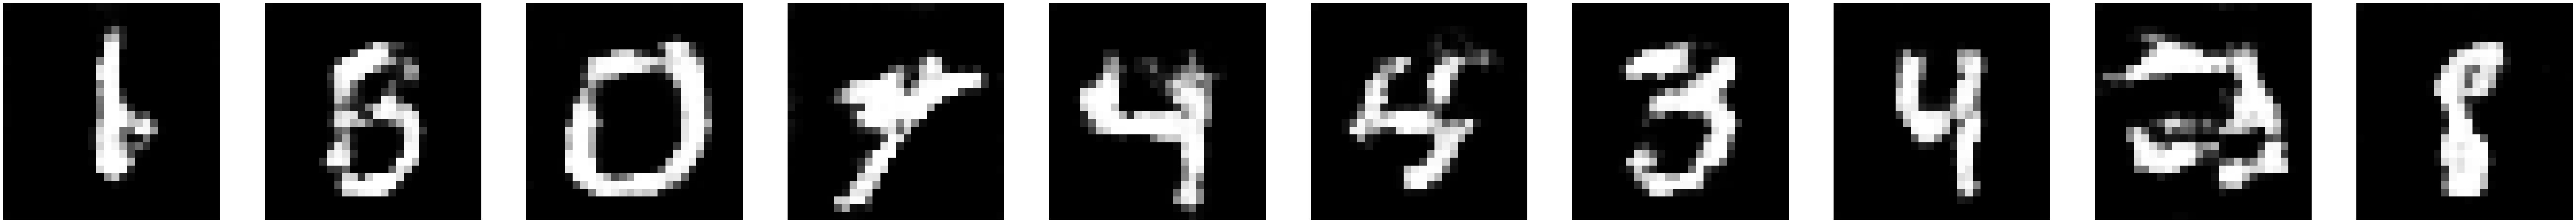

Epoch 18/50


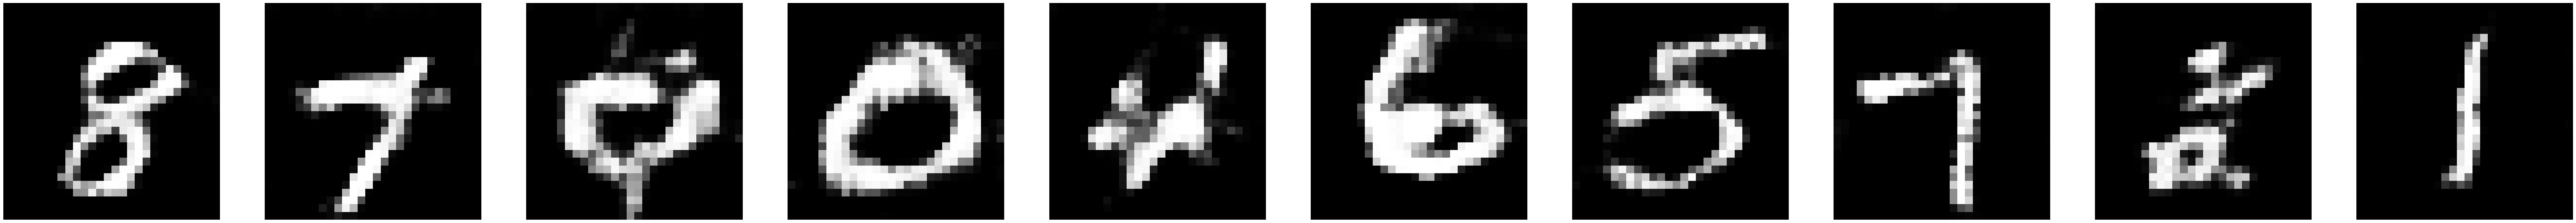

Epoch 19/50


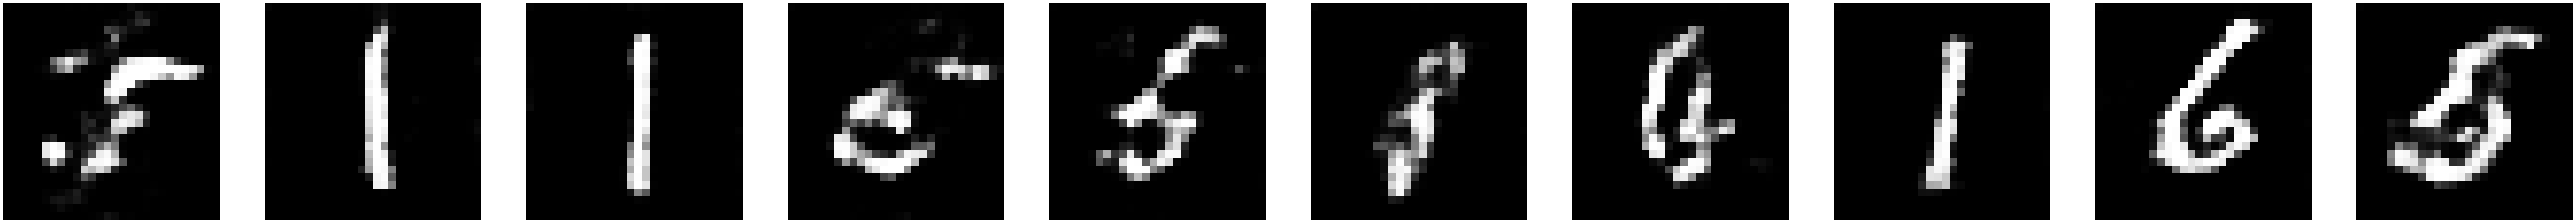

Epoch 20/50


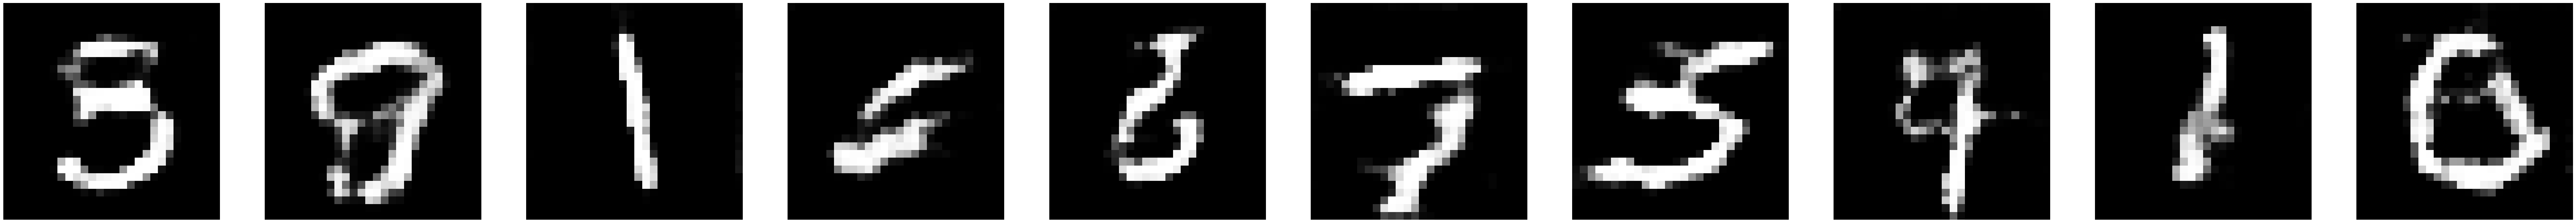

Epoch 21/50


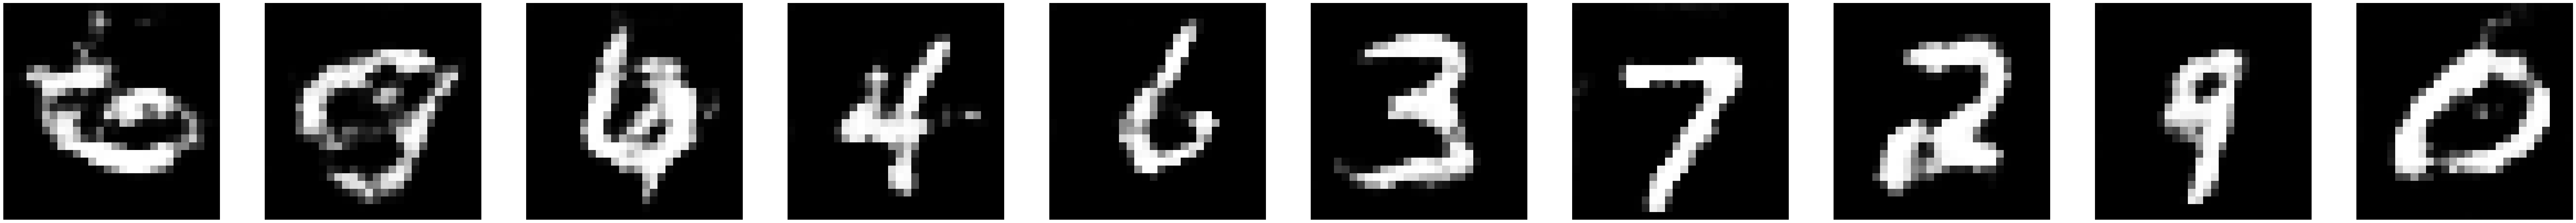

Epoch 22/50


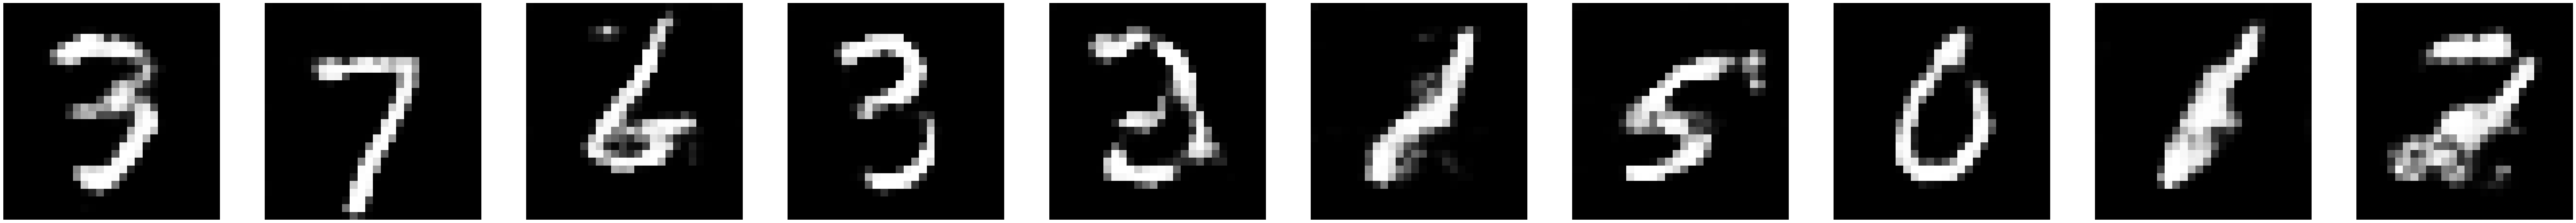

Epoch 23/50


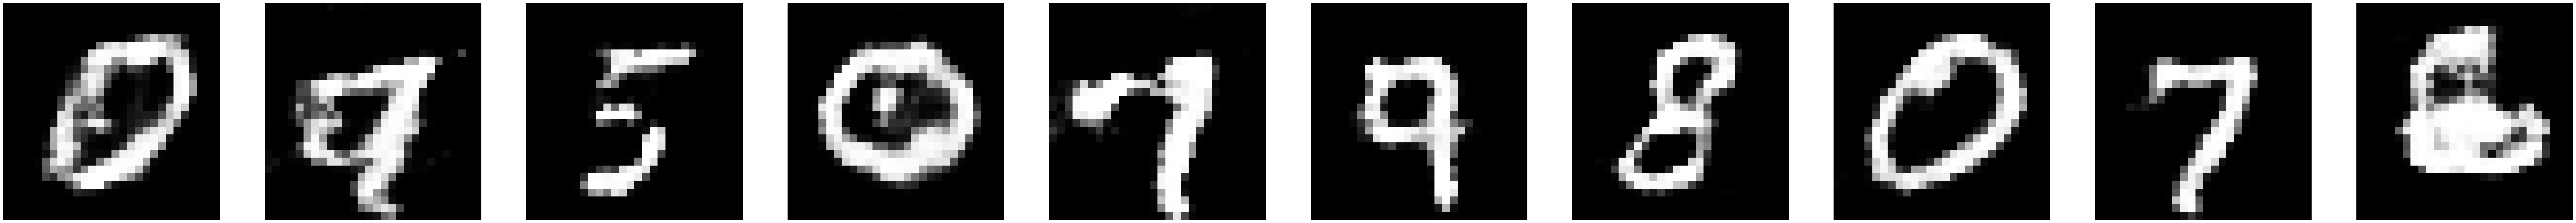

Epoch 24/50


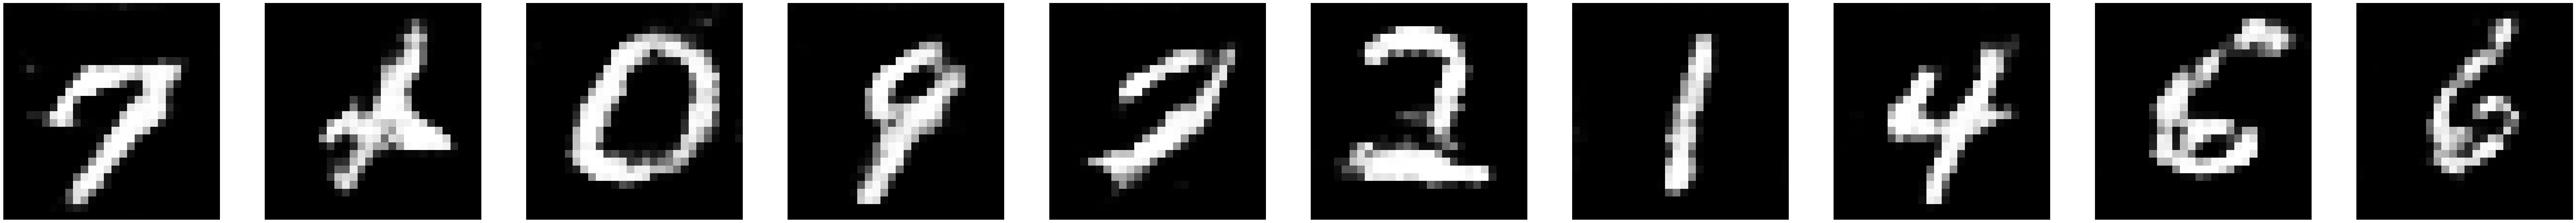

Epoch 25/50


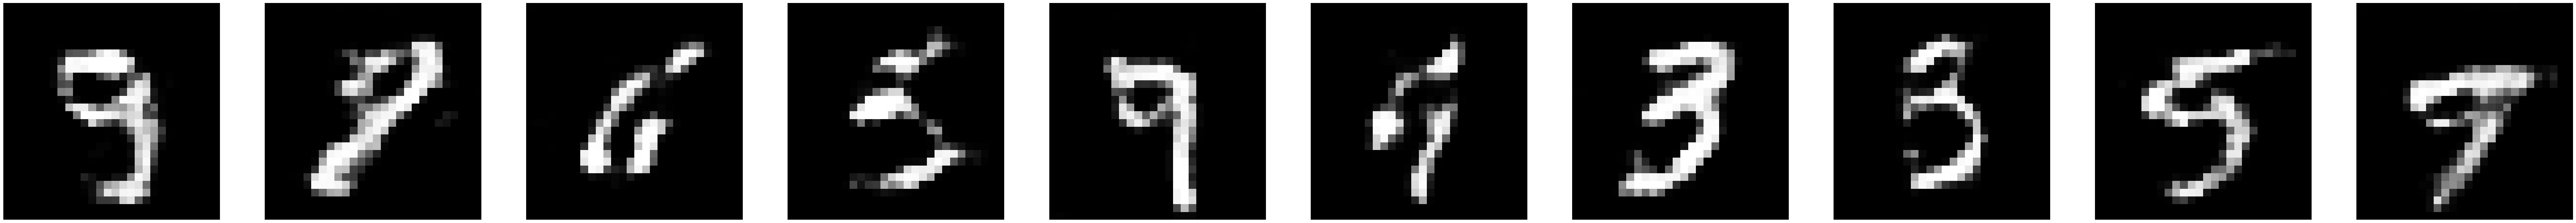

Epoch 26/50


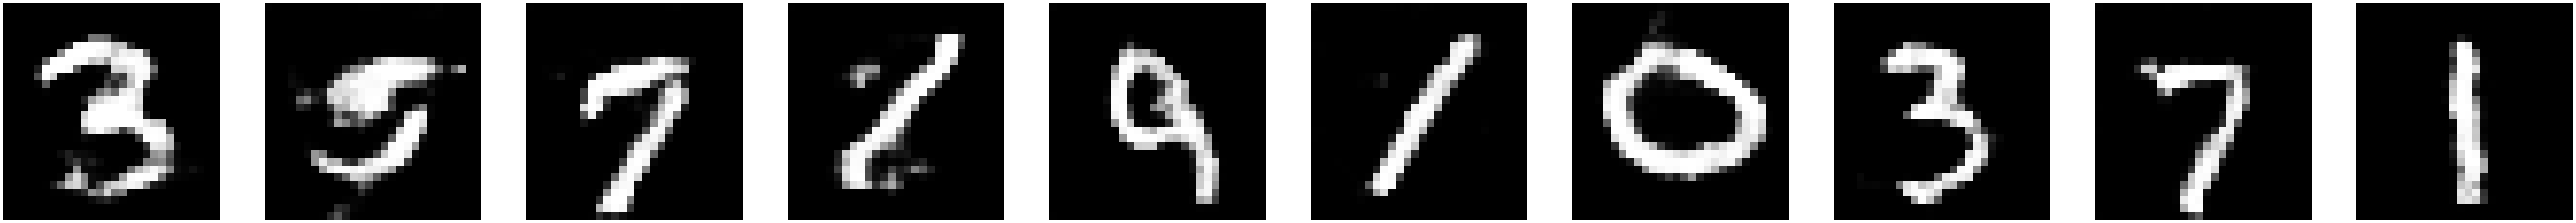

Epoch 27/50


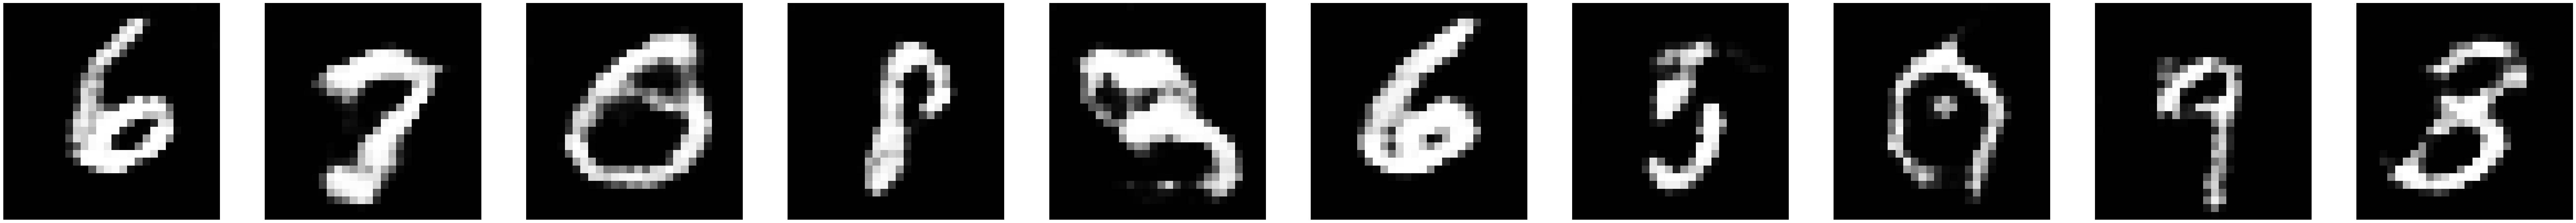

Epoch 28/50


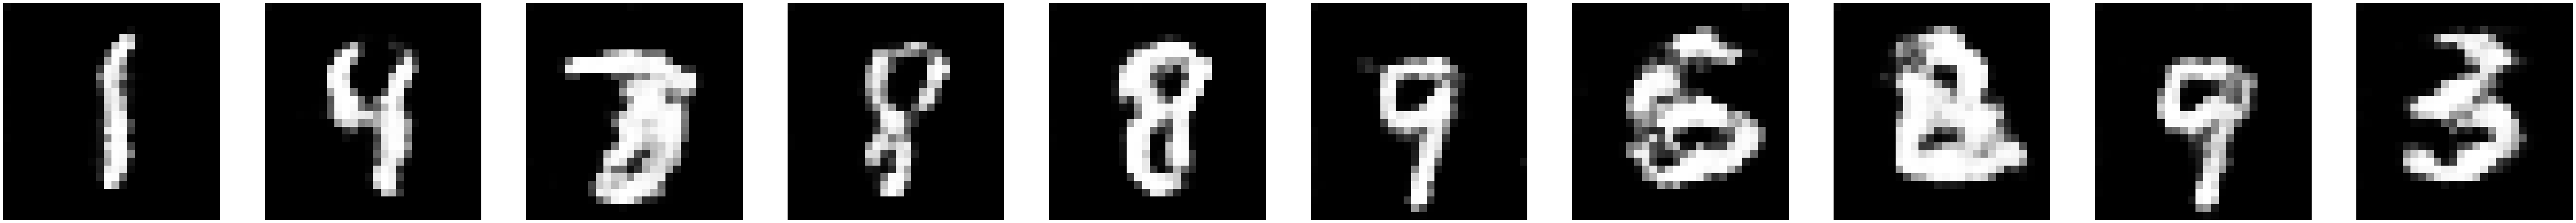

Epoch 29/50


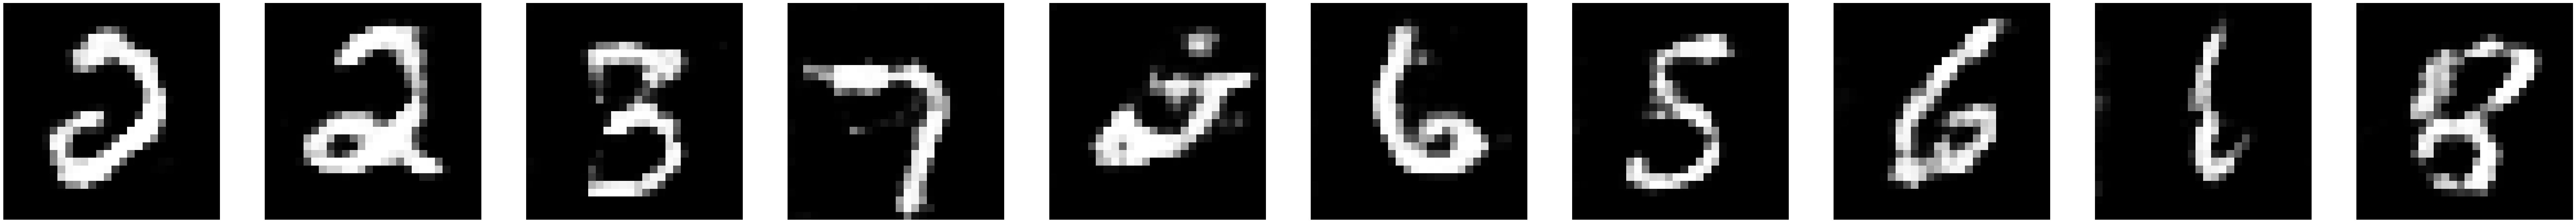

Epoch 30/50


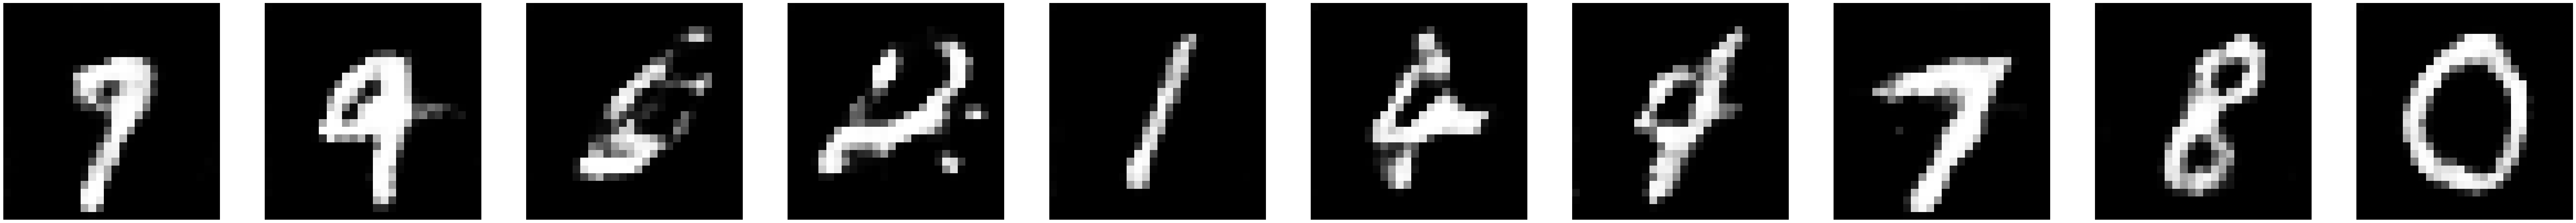

Epoch 31/50


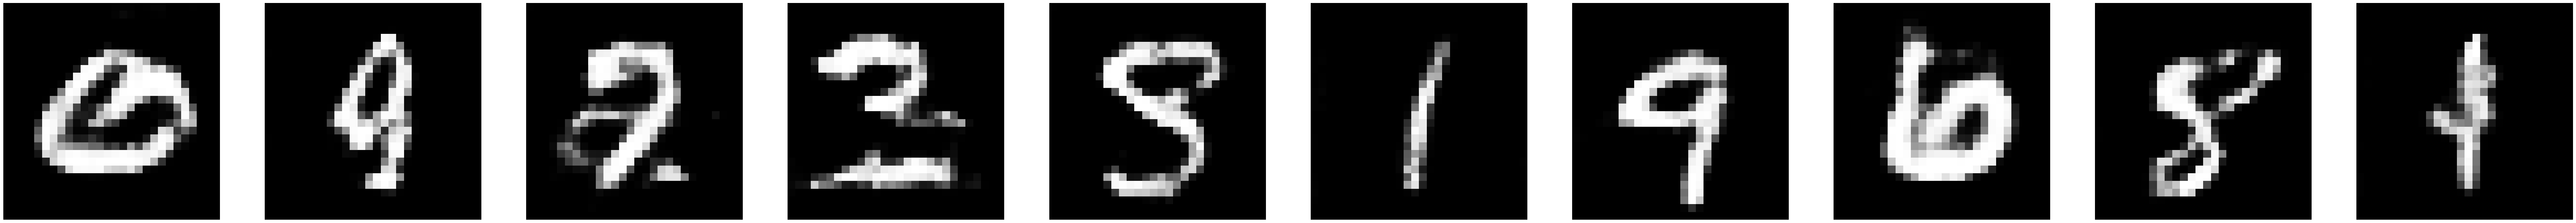

Epoch 32/50


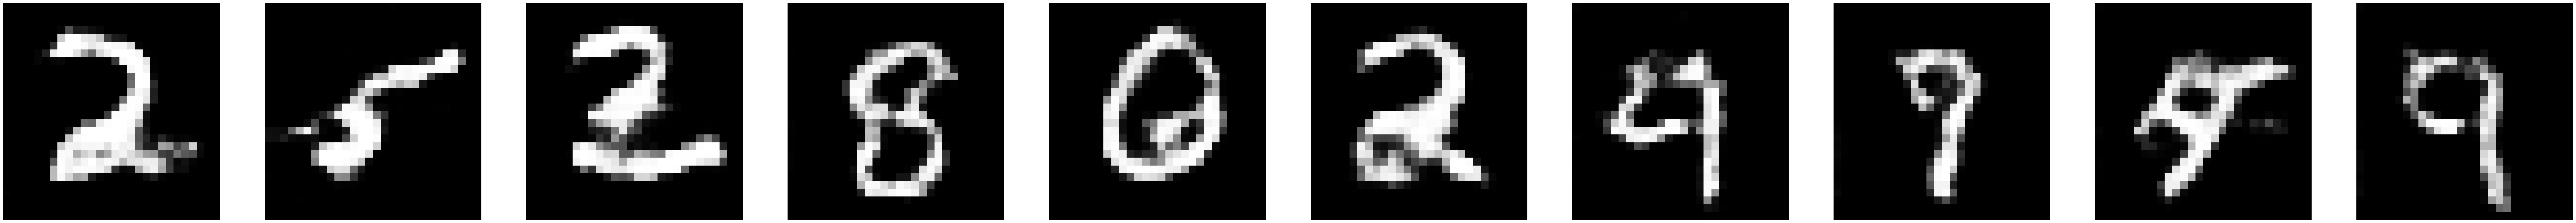

Epoch 33/50


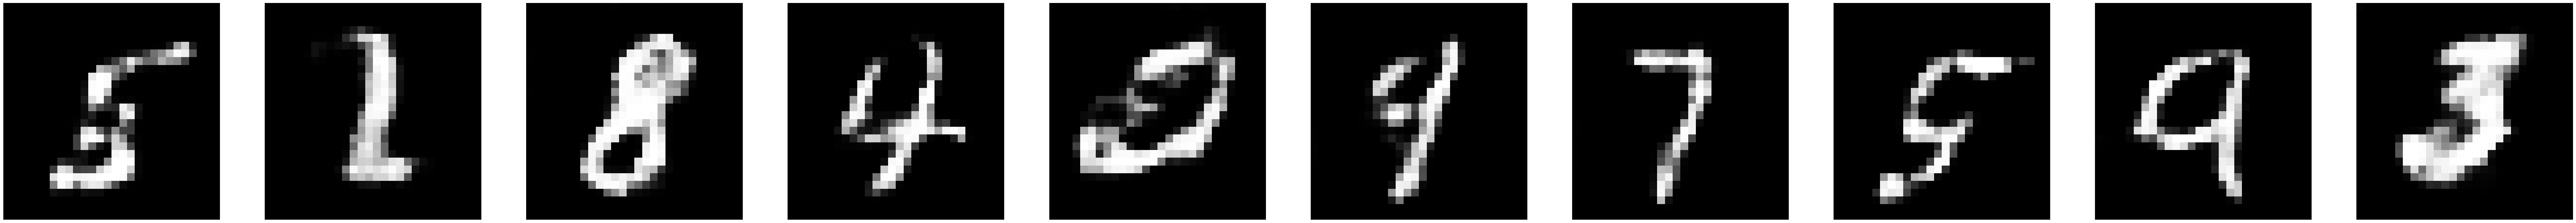

Epoch 34/50


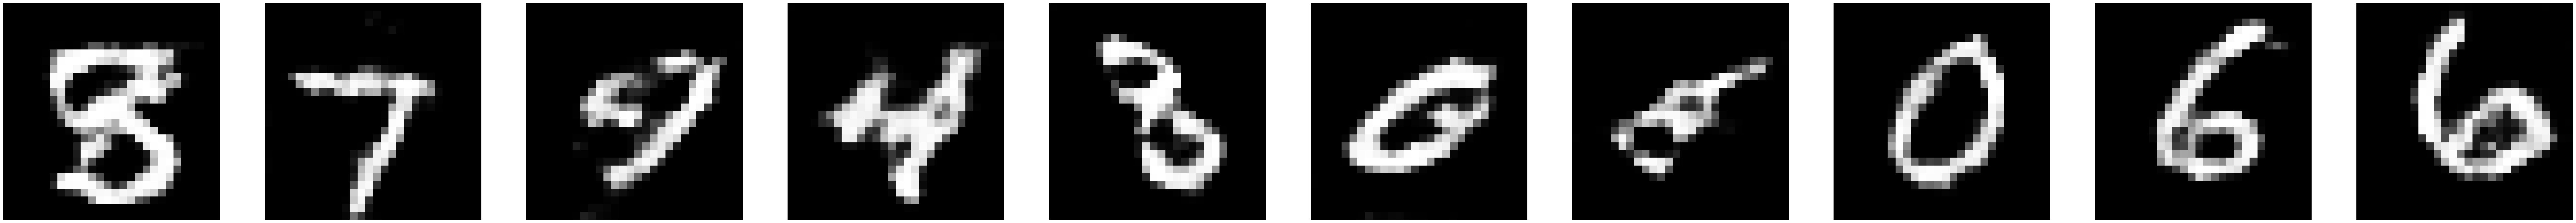

Epoch 35/50


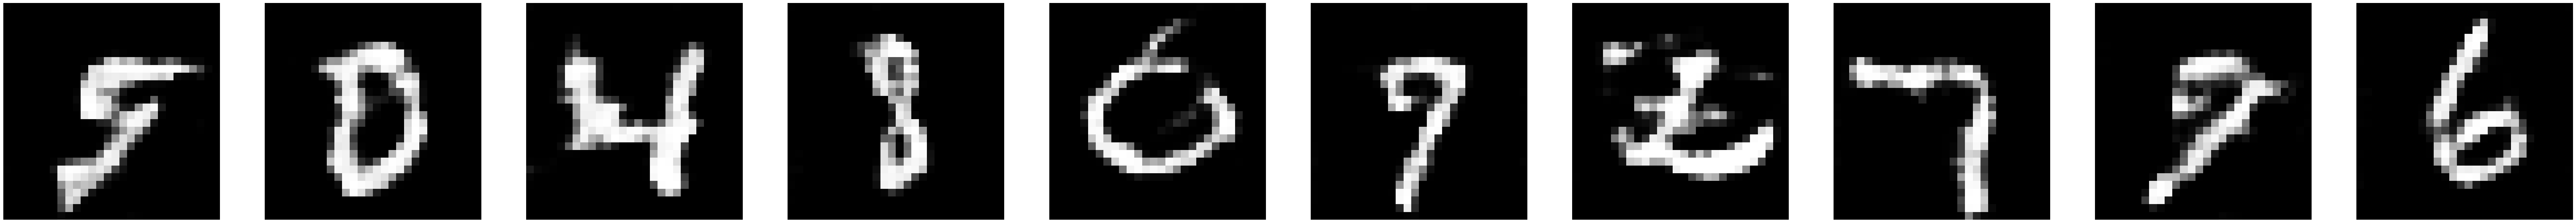

Epoch 36/50


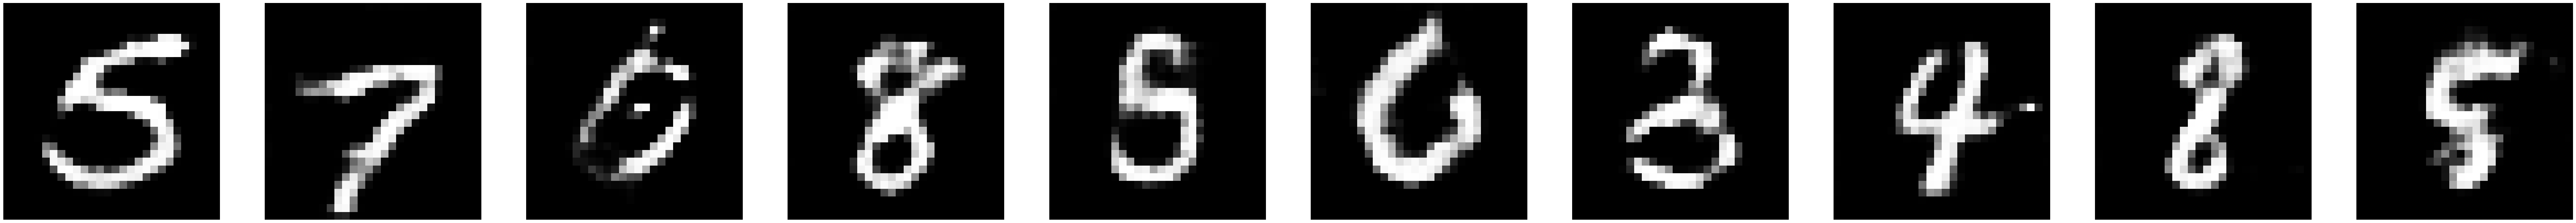

Epoch 37/50


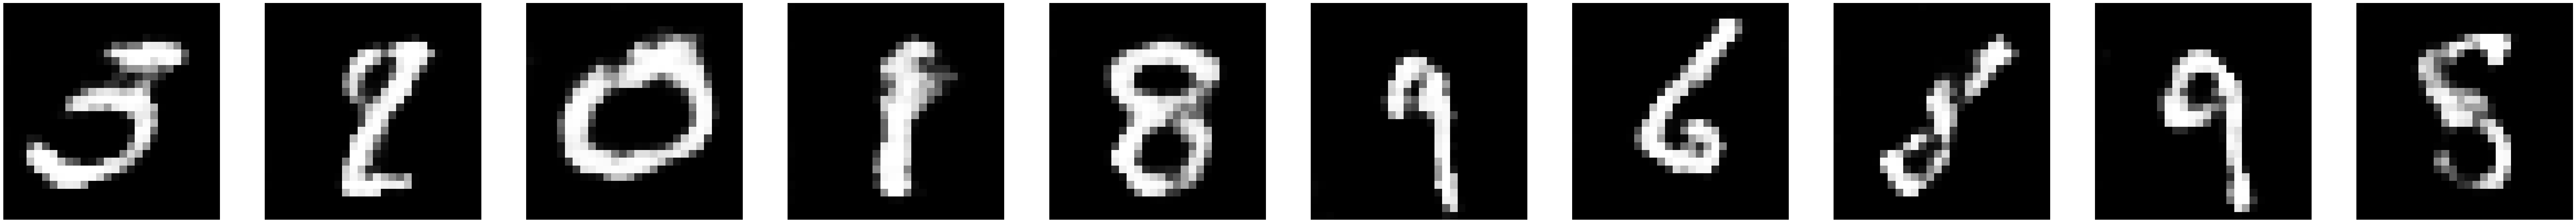

Epoch 38/50


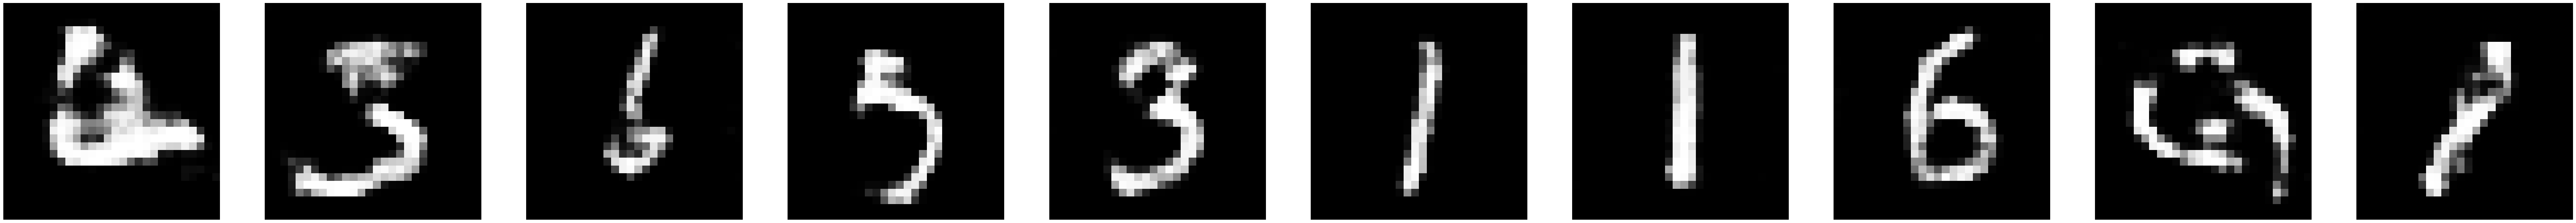

Epoch 39/50


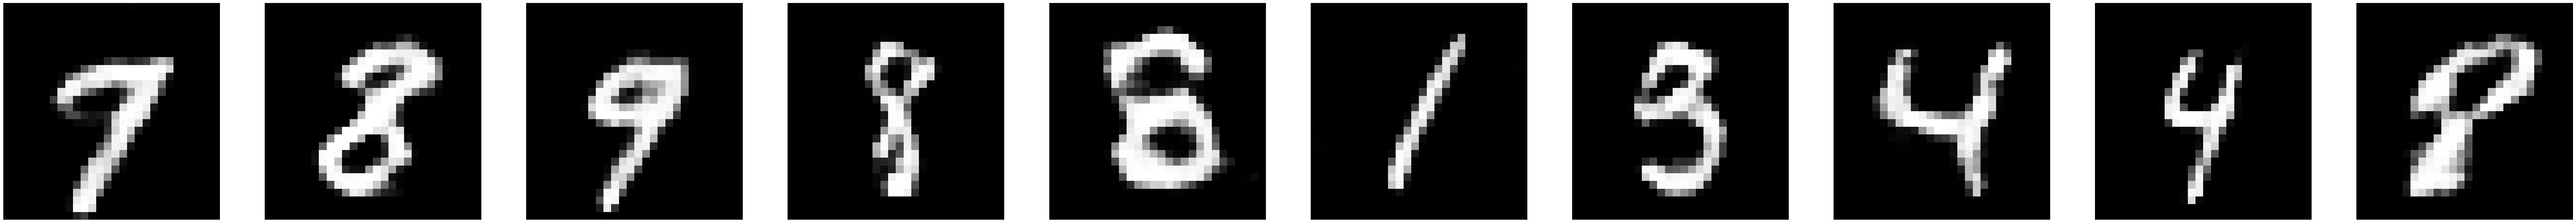

Epoch 40/50


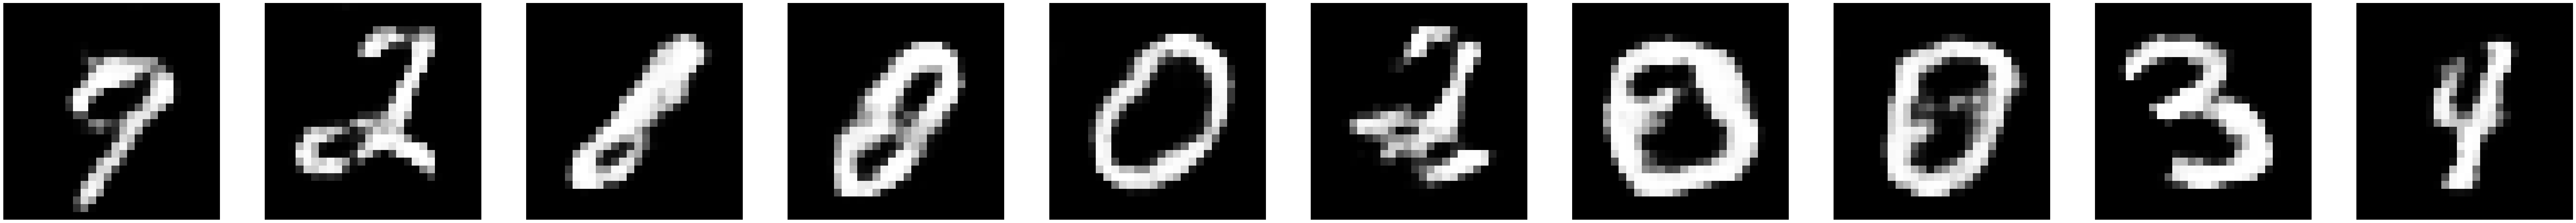

Epoch 41/50


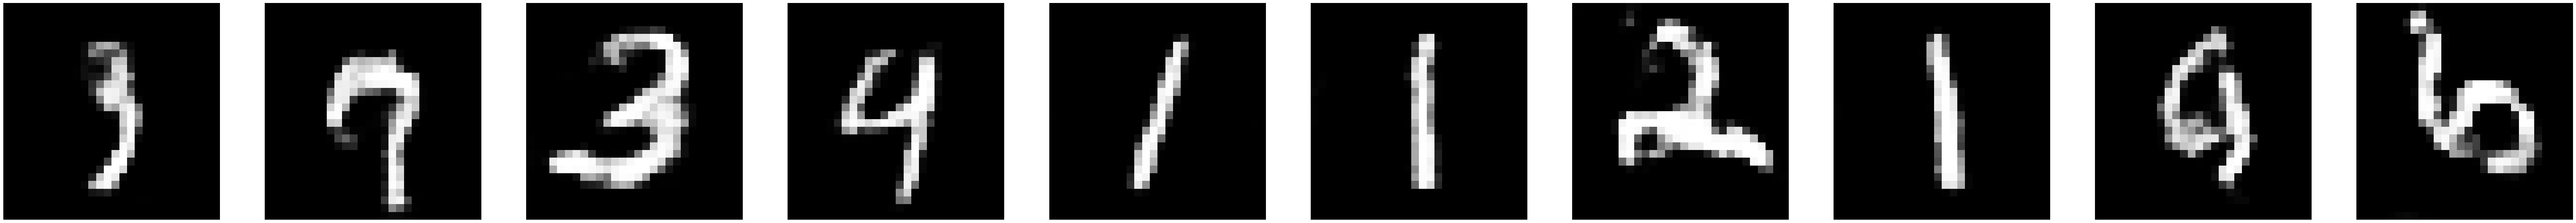

Epoch 42/50


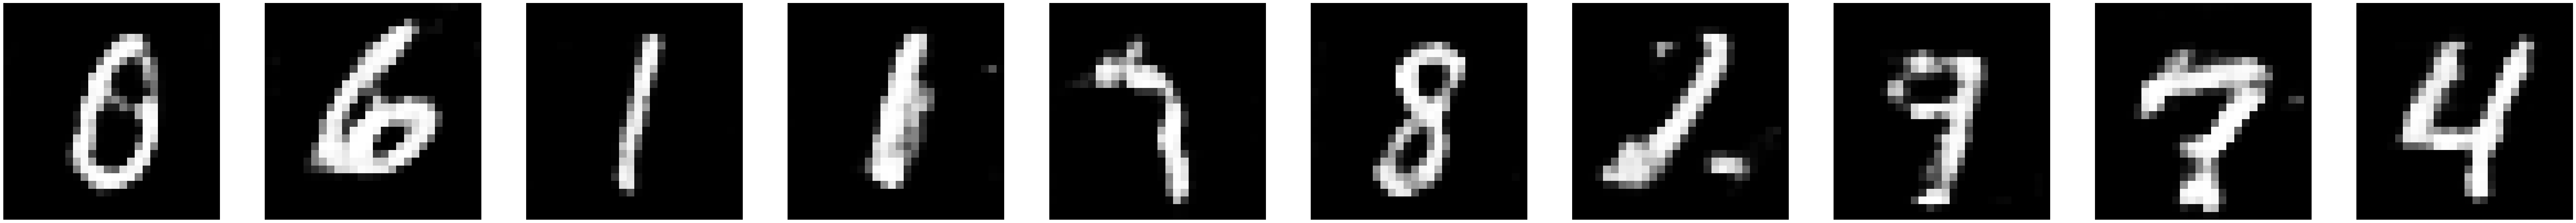

Epoch 43/50


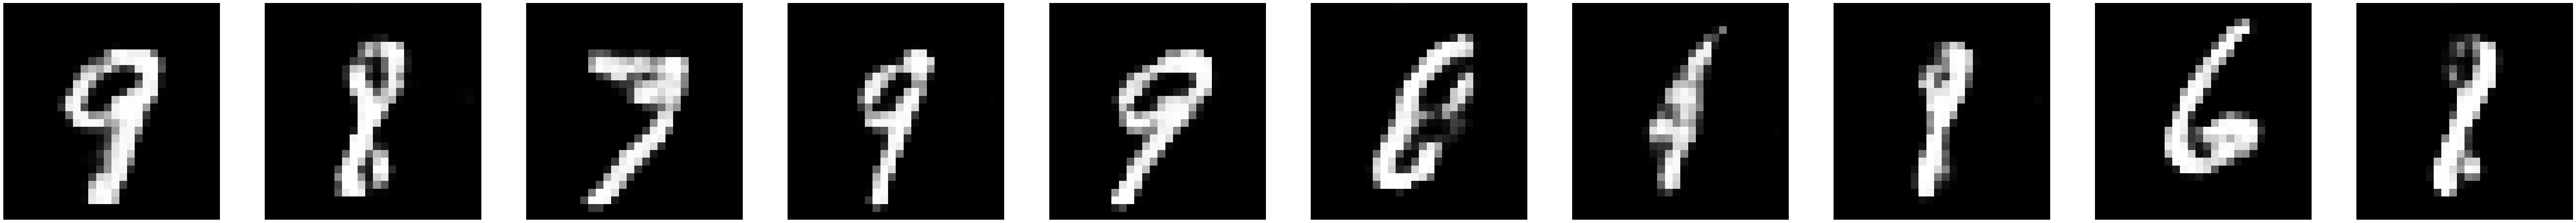

Epoch 44/50


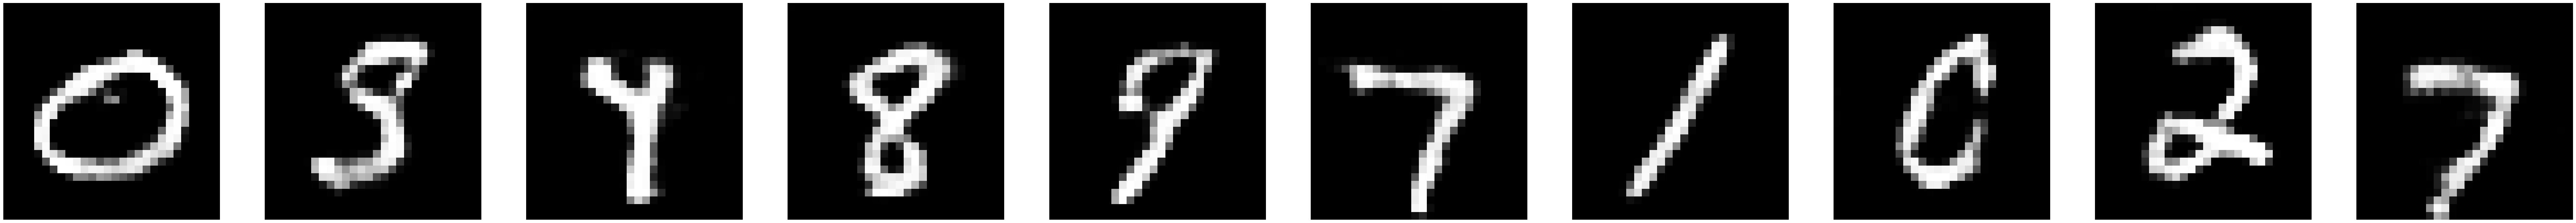

Epoch 45/50


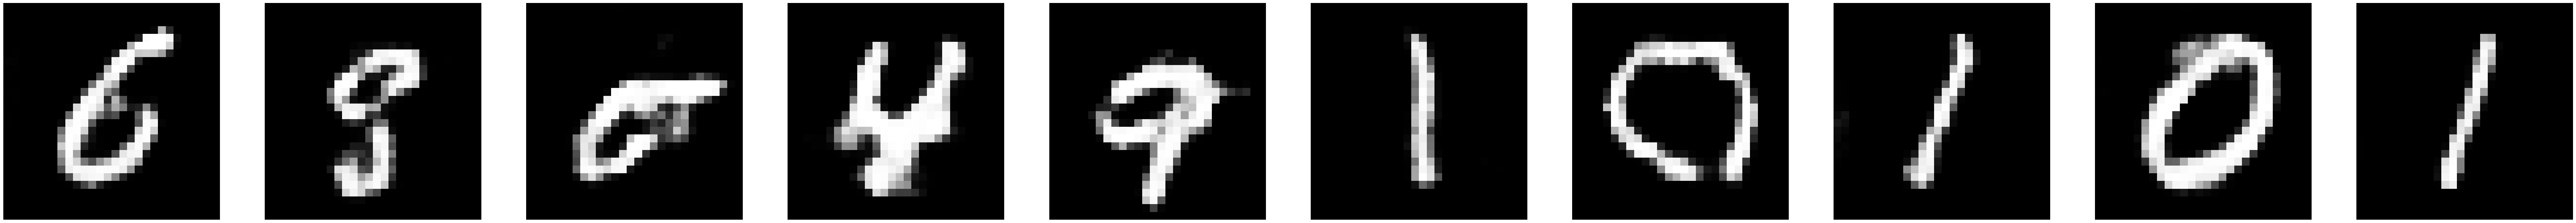

Epoch 46/50


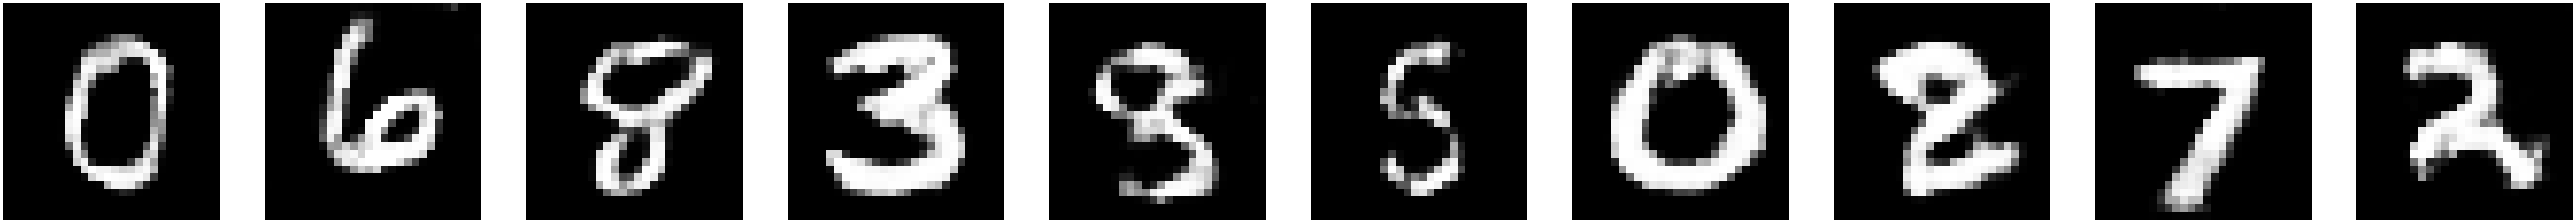

Epoch 47/50


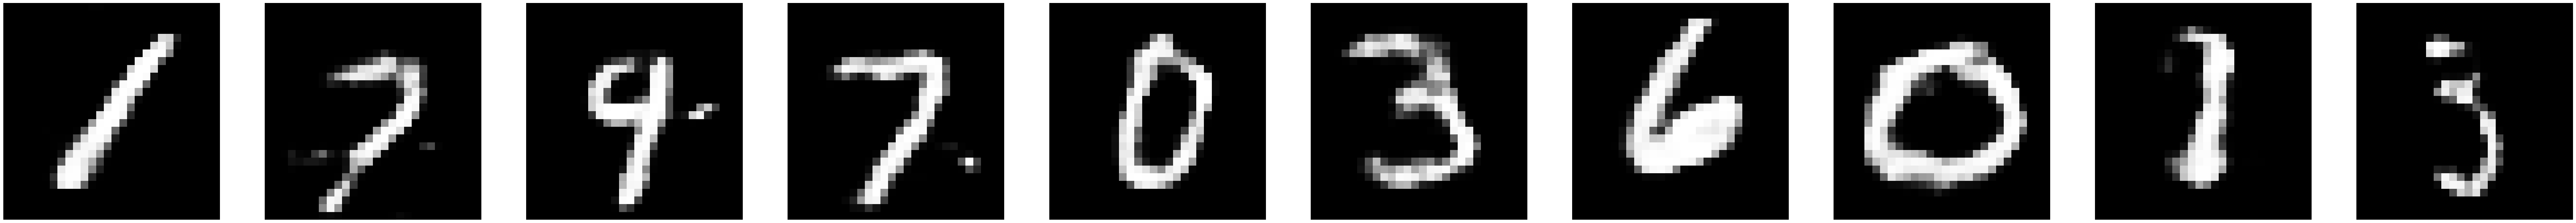

Epoch 48/50


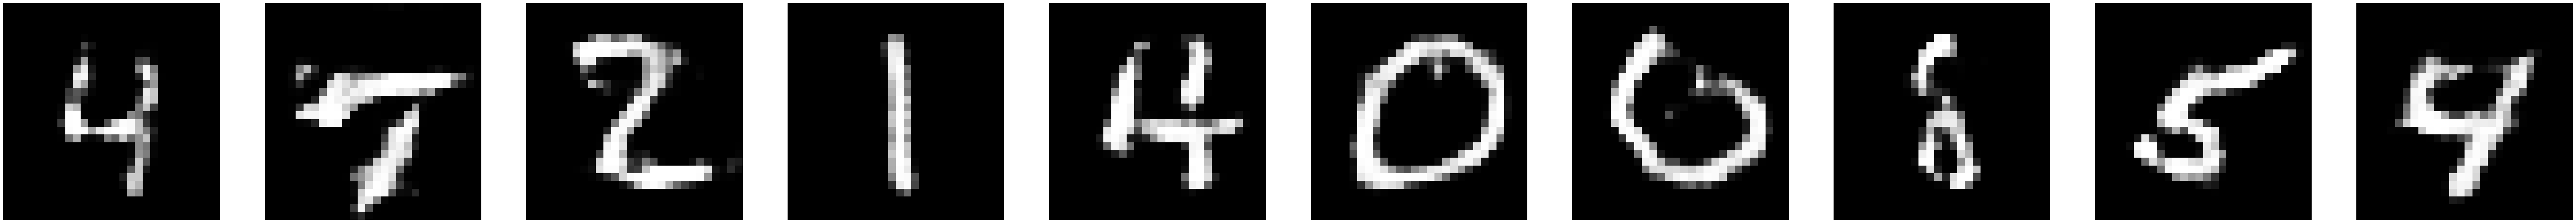

Epoch 49/50


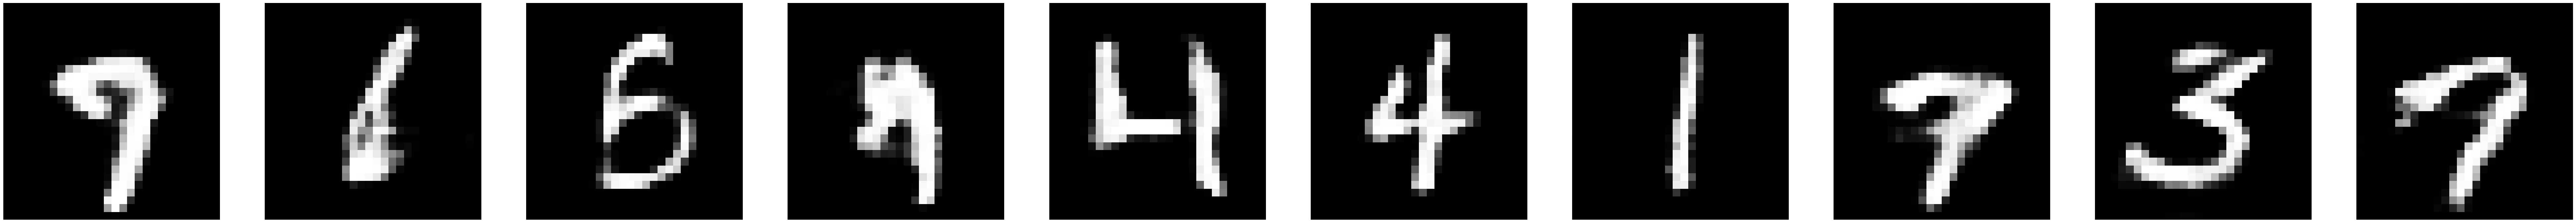

In [19]:
input_distribution_size = 100
learning_rate = 1e-4
batch_size = 256
num_epochs = 50

generator = Generator()
discriminator = Discriminator()
noise = NoiseGenerator(input_distribution_size)
d_optim = tf.optimizers.Adam(learning_rate)
g_optim = tf.optimizers.Adam(learning_rate)

train_step = train_step_template(
    generator=generator,
    discriminator=discriminator,
    noise=noise,
    d_optim=d_optim,
    g_optim=g_optim,
    d_loss_f=w_discriminator_loss,
    g_loss_f=w_generator_loss,
)

gen_step = gen_step_template(
    generator=generator,
    noise=noise
)

train(
    train_step=train_step,
    gen_step=gen_step,
    batch_size=batch_size,
    epochs=num_epochs
)

# Zadanie 2

Wykonaj eksperyment polegający na wygenerowaniu obrazów ''pomiędzy'' trzema cyframi: 8, 3 i 7. Wygenerowanie powinno polegać na znalezieniu reprezentatywnych szumów wejściowych z których generator jest w stanie wygenerować obrazy cyfr, a następnie interpolowaniu liniowym pomiędzy znalezionymi wektorami i wygenerowaniu wyników pośrednich. Generowanie powinno odbywać się przy pomocy generatora wyuczonego z poprzednich zadań.

Interpolacja powinna zawierać po 20 kroków pośrednich pomiędzy parami (8, 3) i (3, 7).

**Uwaga: najprostszy sposób na znalezienie szumu z którego otrzymujemy daną cyfrę jest losowe odpytywanie modelu i zapisanie takiego wektora, który prowadzi do tej cyfry.**

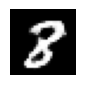

In [88]:
tf.random.set_seed(984)
np.random.seed(42)
one_input = tf.random.normal([1, 100])
one_output = generator(one_input, training=False)

show_images(one_output)

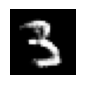

In [31]:
tf.random.set_seed(115)
np.random.seed(42)
two_input = tf.random.normal([1, 100])
two_output = generator(two_input, training=False)

show_images(two_output)

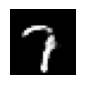

In [92]:
tf.random.set_seed(981)
np.random.seed(42)
three_input = tf.random.normal([1, 100])
three_output = generator(three_input, training=False)

show_images(three_output)

In [93]:
alphas_1 = tf.linspace(0.0, 1.0, 20)
steps_inputs_1 = [(1 - alpha) * one_input + alpha * two_input for alpha in alphas_1]
steps_inputs_1 = tf.concat(steps_inputs_1, axis=0)
steps_outputs_1 = generator(steps_inputs_1, training=False)

alphas_2 = tf.linspace(0.0, 1.0, 20)
steps_inputs_2 = [(1 - alpha) * two_input + alpha * three_input for alpha in alphas_2]
steps_inputs_2 = tf.concat(steps_inputs_2, axis=0)
steps_outputs_2 = generator(steps_inputs_2, training=False)

steps_outputs = tf.concat([steps_outputs_1, steps_outputs_2], 0)

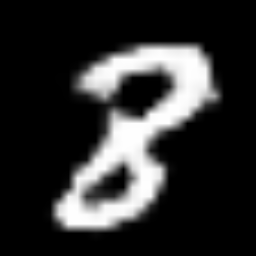

In [94]:
steps_outputs = tf.concat([steps_outputs_1, steps_outputs_2], axis=0)
steps_outputs = tf.image.grayscale_to_rgb(steps_outputs)

show_gif(steps_outputs)